In [ ]:
!pip install -r requirements.txt

In [2]:
!pip freeze > requirements.txt

In [3]:
import subprocess
import re

# Esegui il comando 'pip freeze' e ottieni l'output
result = subprocess.run(['pip', 'freeze'], stdout=subprocess.PIPE)
packages = result.stdout.decode().splitlines()

# Filtrare le linee che contengono "file://"
filtered_packages = [package for package in packages if not re.search(r'file://', package)]

# Scrivere i pacchetti filtrati nel file 'requirements.txt'
with open('requirements.txt', 'w') as file:
    for package in filtered_packages:
        file.write(package + '\n')

print("Il file requirements.txt è stato creato senza stringhe 'file:///home/...'.")


Il file requirements.txt è stato creato senza stringhe 'file:///home/...'.


In [ ]:
!pip install langchain chromadb langchain_community pypdf

In [ ]:
pip cache purge

In [ ]:
!pip install chromadb==0.5.3

In [ ]:
!pip install ragas

In [ ]:
#IMPORTANTE PER FIXARE I CARICAMENTI DEI RISULTATI
!pip install datasets==2.20.0

In [ ]:
pip install groq

In [ ]:
pip install langchain-groq==0.1.6

In [ ]:
pip install openai

In [3]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import CharacterTextSplitter,RecursiveCharacterTextSplitter
from langchain_community.embeddings import OllamaEmbeddings
from langchain.vectorstores import Chroma
from langchain_community.llms import Ollama
from langchain.chains import RetrievalQA, LLMChain
from langchain_groq import ChatGroq

In [4]:
import os
#imposto la chiavi per i servizi che utilizzerò
os.environ["GROQ_API_KEY"] = "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"
os.environ['LANGCHAIN_API_KEY'] = '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'
os.environ["AZURE_OPENAI_API_KEY"] = "21a4eae201494ec581d92fbeb45891b3" #Mbesi Open 9d7cdcf0ed72472dbf75f7e02a25d506 - # Mbesi est 21a4eae201494ec581d92fbeb45891b3

# IMPOSTO AZURE OPENAI

In [5]:
azure_configs = {
    "base_url": "https://mbesiest.openai.azure.com/", # Mbesi open https://mbesiopen.openai.azure.com/ - Mbesi est https://mbesiest.openai.azure.com/
    "model_deployment": "gpt-4o-mini",
    "model_name": "gpt-4o-mini",
    "embedding_deployment": "text-embedding-ada-002",
    "embedding_name": "text-embedding-ada-002",  # most likely  text-embedding-ada-002
}

In [6]:
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from ragas import evaluate

azure_model_GPT3 = AzureChatOpenAI(
    openai_api_version="2024-06-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment="gpt-35-turbo",
    model="gpt-35-turbo",
    validate_base_url=False,
)
azure_model_GPT4OMINI = AzureChatOpenAI(
    openai_api_version="2024-06-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["model_deployment"],
    model=azure_configs["model_name"],
    validate_base_url=False,
)

# init the embeddings for answer_relevancy, answer_correctness and answer_similarity
azure_embeddings = AzureOpenAIEmbeddings(
    openai_api_version="2024-02-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["embedding_deployment"],
    model=azure_configs["embedding_name"],
)

# INPUT E CHUNK DEL FILE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path='documenti/DomandeRisposte.csv', csv_args={
    'delimiter': ';',
    'quotechar': '"',
    'fieldnames': ['Domande', 'Risposte']
})

docs = loader.load()

NUOVO DATASET COMPLETO

In [7]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path='documenti/DomandeRisposteNew.csv', csv_args={
    'delimiter': ';',
    'quotechar': '"',
    'fieldnames': ['DOMANDE', 'RISPOSTE']
})

docs = loader.load()

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path='/content/drive/MyDrive/Magistrale Privata/Progetto Tesi/pdf/DomandeRisposteNew.csv', csv_args={
    'delimiter': ';',
    'quotechar': '"',
    'fieldnames': ['DOMANDE', 'RISPOSTE']
})

docs = loader.load()

In [ ]:
docs

In [8]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=51) #300 - 50/ 250 - 50/ 256 - 25/ 300 - 30

chunks = text_splitter.split_documents(docs)




In [9]:
len(chunks)

1563

In [10]:
# RAGAS expects a file_name dict as key
for document in chunks:
    document.metadata['file_name'] = document.metadata['source']

# CON LLM OPEN

## IMPORTO LIBRERIE - CREO VECTORSTORE, PROMPT E RETRIEVER

In [32]:
import torch
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")


GPU is available


In [ ]:
"""
SE MI TROVO SU COLAB INSTALLO IL TERMINALE PER OLLAMA
#!pip install colab-xterm
%load_ext colabxterm
%xterm
"""

In [ ]:
# scrivo le seguenti linee in entrambi i casi:
#1- curl -faSL https://ollama.com/install.sh | sh
#2- ollama serve & ollama pull gemma2
#3- ollama pull nomic-embed-text
#4- ollama pull llama3

In [11]:
# importo le librerie che utilizzerò
import pandas as pd

from langchain.document_loaders import DirectoryLoader # se carico direttamente una cartella di documenti
#from langchain_openai import ChatOpenAI, OpenAIEmbeddings # se utilizzo openai
from langchain_community.embeddings import OllamaEmbeddings


from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

In [12]:
embeddings = OllamaEmbeddings(model="nomic-embed-text")
#embeddings = OllamaEmbeddings(model="mxbai-embed-large")

In [104]:
from tqdm import tqdm
import time

# Simuliamo il tempo di esecuzione per la dimostrazione
start_time = time.time()

# Crea un oggetto tqdm per monitorare l'avanzamento
with tqdm(total=100) as pbar:
    # Simulazione dell'elaborazione (ad esempio per un loop sui chunks)
    vectorstore = Chroma.from_documents(chunks, embeddings, persist_directory="./chroma_db/med256_db")
    
    # Aggiornamento della barra di caricamento
    pbar.update(100)

# Calcolo del tempo di esecuzione
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time:.2f} secondi")


100%|██████████| 100/100 [04:57<00:00,  2.97s/it]

Tempo di esecuzione: 297.15 secondi


In [15]:
vectorstore = Chroma.from_documents(chunks, embeddings, persist_directory="./chroma_db/med256_db")
#, persist_directory="./chroma_db/txt_db"

In [13]:
# In caso ho l'ho già creato, carico database vettoriale
vectorstore = Chroma(persist_directory="./chroma_db/med_db", embedding_function = embeddings) #med256 per il vectorstore diviso in 256 chunk


/tmp/ipykernel_56709/155641289.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectorstore = Chroma(persist_directory="./chroma_db/med_db", embedding_function = embeddings) #med256 per il vectorstore diviso in 256 chunk
⚠️ It looks like you upgraded from a version below 0.6 and could benefit from vacuuming your database. Run chromadb utils vacuum --help for more information.


In [14]:
#dimostro che il caricamento è avvenuto correttamente
docum = vectorstore.similarity_search("come curo l'ipertensione?")
print(docum[0].page_content)

DOMANDE: L'ipertensione può essere completamente curata?
RISPOSTE: Purtroppo, l'ipertensione non può essere completamente curata, ma può essere gestita efficacemente attraverso cambiamenti nello stile di vita, farmaci e monitoraggio regolare.


In [15]:
vectorstore

In [16]:
retriever = vectorstore.as_retriever(
    search_kwargs={'k': 3}# ritorna i k risultati simili quando eseguo una ricerca sul documento
)

In [ ]:
"""
SOLO SE UTILIZZO GROQ
# llm from groq
llmGroq = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0
)
"""

In [17]:
from langchain_community.llms import Ollama
llm = Ollama(model="llama3.1")

In [206]:
from langchain_core.prompts import PromptTemplate

template = """Sei un assistente medico IA che esegue le istruzioni in modo accurato. Cerca di dare sempre risposte inerenti e dettagliate usando una terminologia medica appropriata ma comprensibile.
Mantieni sempre la riservatezza e il rispetto per la privacy del paziente. Rispondi sempre in italiano alla domanda basata sul contesto. Se è presente nel contesto mi rispondi fornendomi la migliore risposta che riesci a generare.Rispondi "Non sicuro della risposta" se non sei sicuro della risposta.
Se sei sicuro della risposta non c'è bisogno di dirlo.
{context}

Domanda: {question}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context","question"]
  )

In [24]:
#PROMPT MIGLIORATO CON GIANLUCA
from langchain_core.prompts import PromptTemplate

template = """Sei un assistente medico IA. Fornisci risposte accurate e dettagliate in italiano, usando un linguaggio chiaro ma appropriato. Rispetta sempre la privacy del paziente.
Basati sul contesto fornito per rispondere. Se non sei sicuro della risposta, dichiara "Non sicuro della risposta".
{context}

Domanda: {question}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context","question"]
  )

In [143]:
#PROMPT NUOVO FATTO DA ME
from langchain_core.prompts import PromptTemplate

template = """Sei un assistente medico IA italiano esperto, specializzato nel fornire informazioni mediche accurate e pertinenti. Rispondi esclusivamente in italiano, utilizzando un linguaggio chiaro, preciso e adatto al contesto medico.

Istruzioni:
1. Analizza attentamente il contesto fornito e estrai tutte le informazioni rilevanti alla domanda.
2. Fornisci una risposta diretta, completa e ben strutturata basata sulle informazioni presenti nel contesto.
3. Integra le informazioni provenienti da diverse parti del contesto per creare una risposta coerente e completa.
5. Non iniziare la risposta con disclaimer o riferimenti alla fonte delle informazioni. Inizia direttamente con le informazioni pertinenti.
6. Se appropriato, organizza la risposta in punti elenco per una maggiore chiarezza.
7. Mantieni un tono professionale ma accessibile, adatto a un paziente che cerca informazioni mediche.
8. Se la domanda richiede un'opinione o una raccomandazione, fornisci informazioni generali basate sul contesto, specificando alla fine della risposta che per consigli personalizzati è necessario consultare un medico.
9. Rispetta sempre la privacy del paziente, evitando di menzionare o dedurre informazioni personali non fornite nel contesto.
10. Se la domanda è presente nel contesto evita di ripeterlo ma rispondi direttamente alla domanda.

Contesto:
{context}

Domanda: {question}

Risposta:
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"]
)

In [18]:
from langchain_core.prompts import PromptTemplate

template = """Sei un assistente medico IA specializzato in ipertensione. Fornisci risposte dettagliate e basate su evidenze scientifiche, mantenendo un linguaggio chiaro e accessibile. Rispetta sempre la privacy del paziente e, se non sei sicuro della risposta, dichiara "Non sicuro della risposta".

Basati sul contesto fornito per rispondere in modo preciso. Includi le raccomandazioni attuali e spiega i concetti medici in modo comprensibile.

Contesto: {context}

Domanda: {question}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"]
)


## IMPOSTO TUTTE LE TIPOLOGIE DI RETRIVER

### BASE RETRIEVER

Retriever base è utilizzato per eseguire una ricerca di somiglianza, trovando i documenti più simili alla query basandosi sui loro vettori

In [19]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
print(rag_chain.invoke("con che modello sto parlando?"))

In [495]:
retriever.invoke("Quali strumenti tecnologici mostrano dati storici e attuali dell'ipertensione? ")

[Document(metadata={'file_name': 'documenti/DomandeRisposteNew.csv', 'row': 1001, 'source': 'documenti/DomandeRisposteNew.csv'}, page_content='DOMANDE: Quali metodi si utilizzano per determinare la presenza di ipertensione?\nRISPOSTE: Per determinare la presenza di ipertensione, è fondamentale eseguire misurazioni ripetute della pressione arteriosa in diverse occasioni e ambienti, utilizzando strumenti accurati come uno sfigmomanometro.'),
 Document(metadata={'file_name': 'documenti/DomandeRisposteNew.csv', 'row': 1116, 'source': 'documenti/DomandeRisposteNew.csv'}, page_content='DOMANDE: Quali test sono necessari per determinare la presenza di ipertensione?\nRISPOSTE: Per determinare la presenza di ipertensione, è importante iniziare con misurazioni regolari della pressione arteriosa, spesso effettuate in diversi momenti della giornata e in varie situazioni.'),
 Document(metadata={'file_name': 'documenti/DomandeRisposteNew.csv', 'row': 640, 'source': 'documenti/DomandeRisposteNew.csv'

### MULTI QUERY RETRIEVER

Il MultiQueryRetriever automatizza l'ottimizzazione dei prompt utilizzando un LLM per generare più query da diverse prospettive relative a una specifica richiesta dell'utente. Per ciascuna query, il sistema recupera un insieme di documenti rilevanti e poi unisce in modo unico i risultati ottenuti da tutte le query, al fine di ottenere un insieme più ampio di documenti potenzialmente utili. Generando diverse prospettive sulla stessa domanda, il MultiQueryRetriever può superare alcune limitazioni del reperimento basato sulla distanza, fornendo così un insieme di risultati più ricco.

In [21]:
from langchain.retrievers import MultiQueryRetriever
final_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=llm)

In [22]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

multirag_chain = (
    {"context": final_retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [164]:
print(multirag_chain.invoke("Come si cura l'ipertensione?"))

Gli specialisti suggeriscono la dietetica mediterranea come il trattamento principale per la prevenzione e il trattamento dell'ipertensione. La dieta mediterranea è ricca di verdure, frutta, cereali integrali e legumi a basso contenuto di grassi saturi e proteine animali. Il grasso dev'essere sostituito dai polisaccharidi come gli acidi oléico e la filatilina che sono contenuti nella quinoa, nei noci, nell'uva, nella vite ed altri legumi, ma non nelle grissotti, nelle uova, nel burro di manzo o altri grassi animali. La dieta mediterranea ha anche il vantaggio di ridurre i livelli di colesterolo e di calciare l'ipertensione. Inoltre, la dieta mediterranea può contribuire a mantenere un peso corporeo normale, che è una delle cause principali dell'ipertensione. 

Alcune persone sono incapaci a combattere l'ipertensione con dietetica sola e perciò devono ricevere il trattamento medicinale. Il trattamento farmacologico consiste nella prescrizione di uno o più medicinali che riducono la pres

### ENSEMBLE RETRIEVER

L'EnsembleRetriever combina i risultati di più retriever, e poi riordina i risultati con l'algoritmo Reciprocal Rank Fusion.

Questo approccio fonde i vantaggi di diversi retriever, come quelli basati su keyword che eccellono nel recupero basato su parole chiave e quelli basati su vettori che eccellono nel recupero semantico, migliorando le prestazioni complessive attraverso questo metodo di "ricerca ibrida".

In [ ]:
!pip install rank_bm25

In [24]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

BM25 è una funzione di ordinamento utilizzata nei sistemi di recupero delle informazioni per stimare la rilevanza dei documenti rispetto a una determinata query di ricerca.

In [25]:
# initialize the bm25 retriever
bm25_retriever = BM25Retriever.from_documents(chunks)
bm25_retriever.k = 2

In [26]:
# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5])

In [27]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

ensemble_chain = (
    {"context": ensemble_retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [169]:
print(ensemble_chain.invoke("Come si cura l'ipertensione?"))

Non esiste una cura definitiva per l'ipertensione. Tuttavia, essa può essere efficacemente gestita con il supporto delle cure mediche, dei cambiamenti nel tuo stile di vita e del monitoraggio regolare della pressione sanguigna a casa. Le cure mediche includono un insieme di farmaci che possono aiutare a ridurre la pressione sanguigna e prevenire complicazioni future. I cambiamenti nel tuo stile di vita potrebbero includere una dieta equilibrata, regolare esercizio fisico, riduzione del consumo di sali e di etanolo, e perdita di peso se necessario. Il monitoraggio della pressione sanguigna a casa aiuta a monitorare la pressione sanguigna, rilevando eventuali variazioni che possono essere un indicatore delle condizioni mediche coinvolte nel processo di ipertensione. Se non sei sicuro della risposta, chiedi il supporto del tuo medico per una valutazione accurata e la gestione appropriata dell'ipertensione.


## ISTANZIO IL GENERATORE DEL DATA TEST E LO ESEGUO

In [29]:
generator_llm = Ollama(model="llama3.1")
critic_llm = Ollama(model="qwen2")

ollama_emb = OllamaEmbeddings(
    model="nomic-embed-text",
    #model="mxbai-embed-large"
)

print('Generator LLM: '+ generator_llm.invoke('Salutami in italiano'))
print('Critic LLM: '+ critic_llm.invoke('Salutami in italiano e dimmi chi sei'))

r2 = ollama_emb.embed_query(
    "dimmi la seconda lettera dell'alfabeto greco"
)

print(f'Dimensione Embedding: {len(r2)}')

Generator LLM: Piacere!
Critic LLM: Ciao! Mi chiamo AI, assistente virtuale. Sono qui per aiutarti con le tue domande e problemi. Come posso aiutarti oggi?
Dimensione Embedding: 768


In [ ]:
#ESEMPIO FUNZIONANTE
import nest_asyncio
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

# Applica il fix per i loop di eventi annidati
nest_asyncio.apply()

generator = TestsetGenerator.from_langchain(
    generator_llm=generator_llm,
    critic_llm=critic_llm,
    embeddings=ollama_emb
)

testset = generator.generate_with_langchain_docs(chunks, test_size=10,  distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25}, raise_exceptions=False)

## USO AZURE OPENAI

In [403]:
#print(azure_model_GPT3.invoke('Salutami in italiano e dimmi chi sei e che modello utilizzi per rispondere alle domande'))
print(azure_model_GPT4OMINI.invoke('Salutami in italiano e dimmi chi sei e che modello utilizzi per rispondere alle domande'))
r2 = azure_embeddings.embed_query(
    "dimmi la seconda lettera dell'alfabeto greco"
)

print(f'Dimensione Embedding: {len(r2)}')

content="Ciao! Sono un'intelligenza artificiale sviluppata da OpenAI, basata sul modello GPT-3. Posso rispondere a domande, fornire informazioni e aiutarti con vari argomenti. Come posso assisterti oggi?" response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 28, 'total_tokens': 79}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='run-a7a8aa16-1690-4911-9244-e6023bb4ce1a-0' usage_metadata={

In [375]:
import nest_asyncio
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

# Applica il fix per i loop di eventi annidati
nest_asyncio.apply()

generator = TestsetGenerator.from_langchain(
    generator_llm=azure_model_GPT4OMINI, critic_llm=azure_model_GPT4OMINI, embeddings=azure_embeddings
)

testset = generator.generate_with_langchain_docs(
    chunks,
    test_size=20,
    raise_exceptions=False,
    with_debugging_logs=False,
    distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25}
)

embedding nodes:   0%|          | 0/3126 [00:00<?, ?it/s]

Filename and doc_id are the same for all nodes.


Generating:   0%|          | 0/20 [00:00<?, ?it/s]

## PROVO CON ADAPTER PER LA LINGUA

In [395]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context,conditional

# adatto la lingua
language = "italian"

generator.adapt(language, evolutions=[simple, reasoning,conditional,multi_context])
generator.save(evolutions=[simple, reasoning, multi_context,conditional])


In [ ]:
# Imposto la distribuzione

import nest_asyncio

distributions = {
    simple:0.4,
    reasoning:0.2,
    multi_context:0.2,
    conditional:0.2
    }
# Applica il fix per i loop di eventi annidati
nest_asyncio.apply()

generator = TestsetGenerator.from_langchain(
    generator_llm=azure_model_GPT4OMINI, critic_llm=azure_model_GPT4OMINI, embeddings=azure_embeddings
)


testset = generator.generate_with_langchain_docs(chunks, 20,distributions, raise_exceptions=False)
testset.to_pandas()

## Creo il testset e il csv

In [397]:
testset.to_pandas()
test_df= testset.to_pandas()

In [ ]:
#creo il csv del test set
test_df.to_csv('test_dataGPT4OMINIADAPTER.csv', index=False ) #cambia nome
test_df

## IMPORTO METRICHE RAGAS

In [2]:
from ragas import evaluate
#from ragas.metrics.critique import harmfulness
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_similarity,
   #context_relevancy,
    context_recall,
    context_precision,
    answer_correctness
)


## VALUTAZIONE CON METRICHE RAGAS -BASE RETRIEVER

In [399]:
questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

In [170]:
import pandas as pd

# Carica il CSV in un nuovo DataFrame
loaded_df = pd.read_csv('test_dataChatGPT4O_FINALE.csv') #test_dataGPT4OMINI _BUONO / test_dataChatGPT4O_BUONO (sembra ottenere risultati migliori con gpt4O)

# Estrai le colonne 'question' e 'ground_truth'
questions = loaded_df["question"].to_list()
ground_truth = loaded_df["ground_truth"].to_list()


In [171]:
#PER CAMBIARE LLM DI VALUTAZIONE TUTTI I RETRIEVER FARANNO RIFERIMENTO
llm = Ollama(model="echelonify/med-qwen2") #echelonify/med-qwen2

In [145]:
from datasets import Dataset
from tqdm import tqdm

# Assicurati che questions e ground_truth siano definiti
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

# Utilizzo di tqdm per creare una barra di avanzamento
for query in tqdm(questions, desc="Processing queries"):
    data["question"].append(query)
    data["answer"].append(rag_chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

dataset = Dataset.from_dict(data)


Processing queries: 100%|██████████| 18/18 [01:00<00:00,  3.35s/it]


In [146]:
dataset.to_pandas()
datacompleto= dataset.to_pandas()
datacompleto.to_csv('DataCompletoQWENMED5.csv', index=False)
#datacompleto

In [149]:
#SE LO IMPORTO DAI DATAFRAME PRECEDENTI

import pandas as pd
from datasets import Dataset

# Leggi il file CSV in un DataFrame di Pandas
dataframe = pd.read_csv('DataCompletoQWENMED.csv')

# Converti il DataFrame in un dataset Hugging Face
datasetImportato = Dataset.from_pandas(dataframe)

# Mostra il dataset
print(datasetImportato)


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 18
})


In [ ]:
#PER TESTARE SINGOLA METRICA
score = evaluate(dataset,metrics=[answer_relevancy, faithfulness], llm=azure_model_GPT4OMINI, embeddings=azure_embeddings)
score.to_pandas()

In [151]:
score

{'answer_relevancy': 0.7594, 'faithfulness': 0.4398}

In [152]:
DatasetScore= score.to_pandas()
DatasetScore.to_csv('SCOREQWENMED.csv', index=False)

In [107]:
#score nuovo
score

{'answer_relevancy': 0.4109, 'faithfulness': 0.5269}

In [73]:
score

{'answer_relevancy': 0.4178, 'faithfulness': 0.3359}

In [90]:
#score med qwen
score

{'answer_relevancy': 0.6631, 'faithfulness': 0.4591}

In [255]:
%%time
from langchain_core.language_models import BaseLanguageModel
from langchain_core.embeddings import Embeddings
from ragas import evaluate

#langchain_llm =  # any langchain LLM instance
#langchain_embeddings = # any langchain Embeddings instance

resultBase = evaluate(
        dataset = dataset,
        metrics=[
              faithfulness,
              answer_relevancy,
              answer_correctness,
              context_recall,
              context_precision,
              harmfulness
          ],
        llm=generator_llm,
        embeddings=ollama_emb,
        raise_exceptions=False
    )


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[36]: TimeoutError()
Exception raised in Job[38]: TimeoutError()
Failed to parse output. Returning None.


CPU times: user 9.53 s, sys: 553 ms, total: 10.1 s
Wall time: 6min 34s


In [ ]:
resultBase.to_pandas()

## VALUTAZIONE MULTI QUERY RETRIVER

In [91]:
from datasets import Dataset
from tqdm import tqdm

# Assicurati che questions e ground_truth siano definiti
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

# Utilizzo di tqdm per creare una barra di avanzamento
for query in tqdm(questions, desc="Processing queries"):
    data["question"].append(query)
    data["answer"].append(multirag_chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

response_dataset_advanced_retrieval = Dataset.from_dict(data)

Processing queries: 100%|██████████| 18/18 [01:44<00:00,  5.82s/it]


In [ ]:
response_dataset_advanced_retrieval.to_pandas()
responseMultiRetriver= response_dataset_advanced_retrieval.to_pandas()
responseMultiRetriver.to_csv('responseMultiRetriver.csv', index=False)
responseMultiRetriver

In [93]:
#PER TESTARE SINGOLA METRICA
score2 = evaluate(response_dataset_advanced_retrieval,metrics=[answer_relevancy, faithfulness], llm=azure_model_GPT4OMINI, embeddings=azure_embeddings)
score2.to_pandas()

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

,question,answer,contexts,ground_truth,answer_relevancy,faithfulness
0,Quali tipi di farmaci possono essere utilizzat...,"Sulla base delle informazioni fornite, i tipi ...",[DOMANDE: Quali medicinali si possono usare pe...,Esistono diversi tipi di farmaci che possono e...,0.946508,0.000000
1,Come influisce la presenza di familiari con ip...,La presenza di familiari con ipertensione aume...,[DOMANDE: La presenza di familiari con iperten...,"Sì, la presenza di familiari con ipertensione ...",0.972104,0.476190
2,Come può la visione offuscata essere un segnal...,La visione offuscata può essere un segnale imp...,[DOMANDE: Esistono segnali di avvertimento che...,La risposta alla domanda non è presente nel co...,0.894739,0.100000
3,Perché è importante fare regolare attività fis...,La pratica di attività fisica regolare è estre...,[DOMANDE: L'attività fisica effettuata con cos...,Fare regolare attività fisica è importante per...,0.976770,0.235294
4,Quali sintomi possono indicare la presenza di ...,**Sintomi della Pressione Alta**\n\nLa pressio...,[DOMANDE: Che sintomi posso aspettarmi se ho l...,I sintomi possono includere mal di testa persi...,0.959565,0.333333
5,Come posso importare dati storici per confront...,Per poter importare e confrontare i tuoi dati ...,[DOMANDE: Come posso integrare i dati della mi...,Molti software e app di salute permettono di i...,0.966248,0.416667
6,Cosa significa avere la pressione alta?,**La pressione alta (ipertensione) è una condi...,[DOMANDE: Che cosa significa soffrire di press...,L'ipertensione è una condizione in cui la forz...,0.994774,0.692308
7,Come posso rendere le informazioni sui sintomi...,Per rendere le informazioni sui sintomi più ac...,[DOMANDE: In che modo posso monitorare e annot...,Annota i sintomi poco dopo che si sono verific...,0.999999,0.545455
8,Perché è importante fare esercizio fisico mode...,**La regolarità dell'esercizio fisico e la ges...,[DOMANDE: La mia pressione sanguigna è stata i...,La risposta alla domanda non è presente nel co...,0.887136,1.000000
9,Come ridurre il rischio di insufficienza renal...,Non posso fornire indicazioni mediche. Se hai ...,[DOMANDE: Quali effetti può avere l'ipertensio...,Il diabete e l'ipertensione sono strettamente ...,0.000000,0.000000


In [77]:
score2

{'answer_relevancy': 0.5762, 'faithfulness': 0.3835}

In [94]:
score2

{'answer_relevancy': 0.6804, 'faithfulness': 0.3832}

In [259]:
#VALUTO CON CHAT IL MULTIQUERYRETRIVER
resultMulti = evaluate(
        dataset = response_dataset_advanced_retrieval,
        metrics=[
              faithfulness,
              answer_relevancy,
              answer_correctness,
              context_recall,
              context_precision,
              harmfulness
          ],
        llm=generator_llm,
        embeddings=ollama_emb,
        raise_exceptions=False
    )

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Failed to parse output. Returning None.


In [ ]:
resultMulti.to_pandas()

## VALUTAZIONE ENSEMBLE RETRIVER

In [96]:
from datasets import Dataset
from tqdm import tqdm

# Assicurati che questions e ground_truth siano definiti
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

# Utilizzo di tqdm per creare una barra di avanzamento
for query in tqdm(questions, desc="Processing queries"):
    data["question"].append(query)
    data["answer"].append(ensemble_chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

response_dataset_ensemble_retrieval = Dataset.from_dict(data)

Processing queries: 100%|██████████| 18/18 [00:58<00:00,  3.24s/it]


In [ ]:
#PER TESTARE SINGOLA METRICA
score3 = evaluate(response_dataset_ensemble_retrieval,metrics=[answer_relevancy, faithfulness], llm=azure_model_GPT4OMINI, embeddings=azure_embeddings)
score3.to_pandas()

In [81]:
score

{'answer_relevancy': 0.4178, 'faithfulness': 0.3359}

In [82]:
score2

{'answer_relevancy': 0.5762, 'faithfulness': 0.3835}

In [80]:
score3

{'answer_relevancy': 0.6685, 'faithfulness': 0.3907}

In [262]:
#VALUTO CON CHAT IL ENSEMBLERETRIVER
resultEnsemble = evaluate(
        dataset = response_dataset_ensemble_retrieval,
        metrics=[
              faithfulness,
              answer_relevancy,
              answer_correctness,
              context_recall,
              context_precision,
              harmfulness
          ],
        llm=generator_llm,
        embeddings=ollama_emb,
        raise_exceptions=False
    )

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

In [263]:
resultEnsemble.to_pandas()

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,answer_correctness,context_recall,context_precision,harmfulness
0,Does having family members with hypertension i...,"Sì, se nella tua famiglia ci sono casi di iper...",[DOMANDE: La presenza di familiari con iperten...,"Yes, having family members with hypertension c...",1.000000,0.469932,0.674539,1.0,1.000000,0
1,How can oncogenes influence an individual's pr...,"Risposta: Alcuni geni, chiamati oncogeni, poss...",[DOMANDE: In che modo la genetica può aumentar...,Oncogenes can increase the risk of developing ...,0.333333,0.483835,0.685532,1.0,0.916667,0
2,Why is it important to limit the consumption o...,Limiting the consumption of saturated and tran...,[DOMANDE: Quale regime alimentare è consigliat...,The answer to given question is not present in...,0.200000,0.691798,0.135455,0.0,0.000000,0
3,Come può l'ipertensione influenzare la funzion...,L'ipertensione può influenzare la funzione ren...,[DOMANDE: L'ipertensione può influenzare la fu...,L'ipertensione può influenzare la funzione ren...,0.307692,0.486509,0.646043,1.0,1.000000,1
4,Perché è importante consultare il medico prima...,È fondamentale consultare il proprio medico pr...,[DOMANDE: Gli integratori naturali possono con...,È importante consultare il medico prima di usa...,0.727273,0.723105,0.225643,1.0,1.000000,1
5,How does diabetes control reduce renal failure...,Gestione adeguata del diabete può aiutare a ri...,[DOMANDE: Quali sono le cause di un aumento re...,Managing diabetes well can help keep blood pre...,0.363636,0.000000,0.185296,1.0,0.250000,0
6,How does familial hypertension affect health r...,La storia familiare di ipertensione aumenta la...,[DOMANDE: La presenza di familiari con iperten...,"Sì, la presenza di familiari con ipertensione ...",0.285714,0.466311,0.222225,1.0,0.887500,0
7,"How to manage fluctuating BP with stress, diet...",Gestire una pressione arteriosa (BP) che flutt...,[DOMANDE: Quali fattori potrebbero causare var...,"To manage fluctuating blood pressure, it is im...",0.300000,0.482578,0.715944,0.5,0.200000,0
8,Quali precauzioni per iniziare integratori nat...,Risposta: Prima di iniziare a prendere gli int...,[DOMANDE: Gli integratori naturali possono ess...,È importante consultare sempre l'uso degli int...,0.571429,0.732295,0.226807,1.0,1.000000,0
9,Quali valori indicano ipertensione?,I valori che indicano l'ipertensione sono quel...,[DOMANDE: Quali segnali indicano l'ipertension...,La pressione sistolica è pari o superiore a 14...,0.250000,0.817081,0.523642,0.0,0.000000,0


In [265]:
resultBase

{'faithfulness': 0.4701, 'answer_relevancy': 0.4084, 'answer_correctness': 0.3499, 'context_recall': 0.7500, 'context_precision': 0.6583, 'harmfulness': 0.1000}

In [266]:
resultMulti

{'faithfulness': 0.4960, 'answer_relevancy': 0.5769, 'answer_correctness': 0.3759, 'context_recall': 0.8500, 'context_precision': 0.6500, 'harmfulness': 0.1000}

In [267]:
resultEnsemble

{'faithfulness': 0.4339, 'answer_relevancy': 0.5353, 'answer_correctness': 0.4241, 'context_recall': 0.7500, 'context_precision': 0.6254, 'harmfulness': 0.2000}

## VALUTAZIONE DIRETTA CON TUTTI I RETRIEVER

In [ ]:
questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

In [ ]:
import pandas as pd

# Carica il CSV in un nuovo DataFrame
loaded_df = pd.read_csv('test_dataLLAMA3.csv')

# Estrai le colonne 'question' e 'ground_truth'
questions = loaded_df["question"].to_list()
ground_truth = loaded_df["ground_truth"].to_list()

In [ ]:
#PER CAMBIARE LLM DI VALUTAZIONE TUTTI I RETRIEVER FARANNO RIFERIMENTO
llm = Ollama(model="llama3.1:70b")

In [ ]:
from datasets import Dataset
from tqdm import tqdm

# Assicurati che questions e ground_truth siano definiti
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

# Inizializzazione dei tre dizionari
dataset = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}
response_dataset_advanced_retrieval = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}
response_dataset_ensemble_retrieval = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

# Utilizzo di tqdm per creare una barra di avanzamento
for query in tqdm(questions, desc="Processing queries"):
    # Recupero dei documenti rilevanti (assumendo che sia lo stesso per tutte le catene)
    relevant_docs = retriever.get_relevant_documents(query)
    contexts = [doc.page_content for doc in relevant_docs]

    # Popolare il dataset originale
    dataset["question"].append(query)
    dataset["answer"].append(rag_chain.invoke(query))
    dataset["contexts"].append(contexts)

    # Popolare il dataset per advanced retrieval
    response_dataset_advanced_retrieval["question"].append(query)
    response_dataset_advanced_retrieval["answer"].append(multirag_chain.invoke(query))
    response_dataset_advanced_retrieval["contexts"].append(contexts)

    # Popolare il dataset per ensemble retrieval
    response_dataset_ensemble_retrieval["question"].append(query)
    response_dataset_ensemble_retrieval["answer"].append(ensemble_chain.invoke(query))
    response_dataset_ensemble_retrieval["contexts"].append(contexts)

# Convertire i dizionari in Dataset
dataset = Dataset.from_dict(dataset)
response_dataset_advanced_retrieval = Dataset.from_dict(response_dataset_advanced_retrieval)
response_dataset_ensemble_retrieval = Dataset.from_dict(response_dataset_ensemble_retrieval)

# Convertire in DataFrame se necessario
dataset_df = dataset.to_pandas()
advanced_retrieval_df = response_dataset_advanced_retrieval.to_pandas()
ensemble_retrieval_df = response_dataset_ensemble_retrieval.to_pandas()

In [ ]:
%%time
from langchain_core.language_models import BaseLanguageModel
from langchain_core.embeddings import Embeddings
from ragas import evaluate

#langchain_llm =  # any langchain LLM instance
#langchain_embeddings = # any langchain Embeddings instance

resultBase = evaluate(
        dataset = dataset,
        metrics=[
              faithfulness,
              answer_relevancy,
              answer_correctness#,
              #context_recall,
              #context_precision
              #context_relevancy
          ],
        llm=generator_llm,
        embeddings=ollama_emb,
        raise_exceptions=False
    )

resultMulti = evaluate(
        dataset = response_dataset_advanced_retrieval,
        metrics=[
              faithfulness,
              answer_relevancy,
              answer_correctness#,
              #context_recall,
              #context_precision
              #context_relevancy
          ],
        llm=generator_llm,
        embeddings=ollama_emb,
        raise_exceptions=False
    )

resultEnsemble = evaluate(
        dataset = response_dataset_ensemble_retrieval,
        metrics=[
              faithfulness,
              answer_relevancy,
              answer_correctness#,
              #context_recall,
              #context_precision
              #context_relevancy
          ],
        llm=generator_llm,
        embeddings=ollama_emb,
        raise_exceptions=False
    )


## PROCESSO AUTOMATIZZATO CON PIU' LLM

In [ ]:
#SE GIA HO CALCOLATO IL TESTSET
questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

In [28]:
#ALTRIMENTI LO CARICO DAL CSV CHE HO PRESENTE E POI PROCEDO AL CALCOLO
import pandas as pd

# Carica il CSV in un nuovo DataFrame
loaded_df = pd.read_csv('test_dataChatGPT4O_FINALE.csv')

# Estrai le colonne 'question' e 'ground_truth'
questions = loaded_df["question"].to_list()
ground_truth = loaded_df["ground_truth"].to_list()

In [510]:
from datasets import Dataset
from tqdm import tqdm
from langchain.llms import Ollama

# Lista dei modelli da processare
model_names = ["llama3.1","qordmlwls/llama3.1-medical","qwen2","echelonify/med-qwen2","mistral-nemo","phi3","gemma2"] # AGGIUNGERE ALTRI LLM PER POTER VALUTARE

# Assicurati che questions e ground_truth siano definiti
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

# Dizionario per memorizzare i risultati di ogni modello
resultsDict = {}

for model_name in model_names:
    print(f"Processing with model: {model_name}")

    # Inizializza l'LLM per il modello corrente
    llm = Ollama(model=model_name)


    # Inizializzazione dei tre dizionari per il modello corrente
    dataset = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}
    response_dataset_advanced_retrieval = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}
    response_dataset_ensemble_retrieval = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

    # Utilizzo di tqdm per creare una barra di avanzamento
    for query in tqdm(questions, desc=f"Processing queries for {model_name}"):
        # Recupero dei documenti rilevanti (assumendo che sia lo stesso per tutte le catene)
        relevant_docs = retriever.get_relevant_documents(query)
        contexts = [doc.page_content for doc in relevant_docs]

        # Popolare il dataset originale
        dataset["question"].append(query)
        dataset["answer"].append(rag_chain.invoke(query))
        dataset["contexts"].append(contexts)

        # Popolare il dataset per advanced retrieval
        response_dataset_advanced_retrieval["question"].append(query)
        response_dataset_advanced_retrieval["answer"].append(multirag_chain.invoke(query))
        response_dataset_advanced_retrieval["contexts"].append(contexts)

        # Popolare il dataset per ensemble retrieval
        response_dataset_ensemble_retrieval["question"].append(query)
        response_dataset_ensemble_retrieval["answer"].append(ensemble_chain.invoke(query))
        response_dataset_ensemble_retrieval["contexts"].append(contexts)

    # Convertire i dizionari in Dataset
    dataset = Dataset.from_dict(dataset)
    response_dataset_advanced_retrieval = Dataset.from_dict(response_dataset_advanced_retrieval)
    response_dataset_ensemble_retrieval = Dataset.from_dict(response_dataset_ensemble_retrieval)

    # Convertire in DataFrame e memorizzare i risultati
    resultsDict[f"dataset_df_{model_name}"] = dataset.to_pandas()
    resultsDict[f"advanced_retrieval_df_{model_name}"] = response_dataset_advanced_retrieval.to_pandas()
    resultsDict[f"ensemble_retrieval_df_{model_name}"] = response_dataset_ensemble_retrieval.to_pandas()

# Esempio:
# dataset_df_llama3_1_70b = resultsDict["dataset_df_llama3.1:70b"]
# advanced_retrieval_df_qwen2 = resultsDict["advanced_retrieval_df_qwen2"]
# ensemble_retrieval_df_mistral_nemo = resultsDict["ensemble_retrieval_df_mistral-nemo"]

Processing with model: llama3.1


Processing queries for llama3.1: 100%|██████████| 18/18 [05:17<00:00, 17.64s/it]


Processing with model: qordmlwls/llama3.1-medical


Processing queries for qordmlwls/llama3.1-medical: 100%|██████████| 18/18 [05:23<00:00, 17.95s/it]


Processing with model: qwen2


Processing queries for qwen2: 100%|██████████| 18/18 [05:11<00:00, 17.28s/it]


Processing with model: echelonify/med-qwen2


Processing queries for echelonify/med-qwen2: 100%|██████████| 18/18 [05:32<00:00, 18.49s/it]


Processing with model: mistral-nemo


Processing queries for mistral-nemo: 100%|██████████| 18/18 [05:25<00:00, 18.11s/it]


Processing with model: phi3


Processing queries for phi3: 100%|██████████| 18/18 [05:16<00:00, 17.58s/it]


Processing with model: gemma2


Processing queries for gemma2: 100%|██████████| 18/18 [05:32<00:00, 18.46s/it]


In [ ]:
import pickle
# Salva resultsDict su un file per poter riaccedere successivamente
with open('resultsDict_MODELLICOMP.pkl', 'wb') as f: #Cambianome per salvare più modelli 
    pickle.dump(resultsDict, f)

Per accedere al singolo dataset:

In [ ]:
resultsDict[f"dataset_df_phi3"]

In [ ]:
resultsDict[f"advanced_retrieval_df_echelonify/med-qwen2"]

In [ ]:
resultsDict[f"ensemble_retrieval_df_echelonify/med-qwen2"]

In [ ]:
resultsDict

AUTOMATIZZAZIONE DELLA VALUTAZIONE

In [513]:
%%time
from langchain_core.language_models import BaseLanguageModel
from langchain_core.embeddings import Embeddings
from ragas import evaluate
from langchain.llms import Ollama
from datasets import Dataset

# Dizionario per memorizzare i risultati della valutazione
evaluation_results = {}

# Metriche da utilizzare per la valutazione
metrics = [
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
    harmfulness
    
    # context_relevancy NON NECESSARIA QUANTO LE ALTRE DUE
]

# Funzione per convertire DataFrame in Dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(df)

# Itera su tutti i modelli presenti nel dizionario results
for model_name in ["llama3.1","qordmlwls/llama3.1-medical","qwen2","echelonify/med-qwen2","mistral-nemo","phi3","gemma2"]: #AGGIUNGERE ALTRI MODELLI...
    print(f"Evaluating model: {model_name}")


    # Valutazione per il dataset base
    resultBase = evaluate(
        dataset=convert_to_dataset(resultsDict[f"dataset_df_{model_name}"]),
        metrics=metrics,
        llm=azure_model_GPT4OMINI, #azure_model_GPT4OMINI o generator_llm  embeddings=azure_embeddings
        embeddings=azure_embeddings,
        raise_exceptions=False
    )

    # Valutazione per il dataset advanced retrieval
    resultMulti = evaluate(
        dataset=convert_to_dataset(resultsDict[f"advanced_retrieval_df_{model_name}"]),
        metrics=metrics,
        llm=azure_model_GPT4OMINI,
        embeddings=azure_embeddings,
        raise_exceptions=False
    )

    # Valutazione per il dataset ensemble retrieval
    resultEnsemble = evaluate(
        dataset=convert_to_dataset(resultsDict[f"ensemble_retrieval_df_{model_name}"]),
        metrics=metrics,
        llm=azure_model_GPT4OMINI,
        embeddings=azure_embeddings,
        raise_exceptions=False
    )

    # Memorizza i risultati della valutazione per questo modello
    evaluation_results[model_name] = {
        "base": resultBase,
        "multi": resultMulti,
        "ensemble": resultEnsemble
    }

# Stampa un riepilogo dei risultati
for model_name, model_results in evaluation_results.items():
    print(f"\nResults for {model_name}:")
    for dataset_type, result in model_results.items():
        print(f"  {dataset_type.capitalize()} Dataset:")
        for metric, score in result.items():
            print(f"    {metric}: {score:.4f}")

Evaluating model: llama3.1


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating model: qordmlwls/llama3.1-medical


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating model: qwen2


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating model: echelonify/med-qwen2


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating model: mistral-nemo


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating model: phi3


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating model: gemma2


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]


Results for llama3.1:
  Base Dataset:
    faithfulness: 0.3668
    answer_relevancy: 0.7342
    answer_correctness: 0.6568
    context_recall: 0.7491
    context_precision: 0.9815
    harmfulness: 0.1111
  Multi Dataset:
    faithfulness: 0.3468
    answer_relevancy: 0.7365
    answer_correctness: 0.5797
    context_recall: 0.6889
    context_precision: 0.9815
    harmfulness: 0.1667
  Ensemble Dataset:
    faithfulness: 0.3658
    answer_relevancy: 0.6817
    answer_correctness: 0.5797
    context_recall: 0.7028
    context_precision: 0.9815
    harmfulness: 0.0556

Results for qordmlwls/llama3.1-medical:
  Base Dataset:
    faithfulness: 0.4304
    answer_relevancy: 0.7902
    answer_correctness: 0.6729
    context_recall: 0.7491
    context_precision: 0.9815
    harmfulness: 0.1111
  Multi Dataset:
    faithfulness: 0.4009
    answer_relevancy: 0.7408
    answer_correctness: 0.6232
    context_recall: 0.7028
    context_precision: 0.9815
    harmfulness: 0.0556
  Ensemble Dataset:


In [ ]:
evaluation_results

In [514]:
import pickle
# Salva evaluation_results su un file per poter riaccedere successivamente
with open('evaluation_results_MODELLICOMP.pkl', 'wb') as f: #Cambianome per salvare più modelli 
    pickle.dump(evaluation_results, f)

## CARICO MODELLI PER LE ANALISI DA FILE PICKLE

Carico il primo pickle dove ho salvato i risultati del modello qwen 2 med

In [1]:
import pickle
# Carica evaluation_results da un file
with open('evaluation_resultsQWENMED.pkl', 'rb') as f:
    evaluation_resultsQWENMED = pickle.load(f)

In [ ]:
QwenMedBase = evaluation_resultsQWENMED["echelonify/med-qwen2"]["base"].to_pandas()
QwenMedMulti = evaluation_resultsQWENMED["echelonify/med-qwen2"]["multi"].to_pandas()
QwenMedEnsemble = evaluation_resultsQWENMED["echelonify/med-qwen2"]["ensemble"].to_pandas()

Carico il secondo pickle dove ho salvato i risultati degli altri modelli

In [2]:
from datasets import Dataset
import pickle
# Carica evaluation_results da un file
with open('evaluation_results_MODELLICOMP.pkl', 'rb') as f:
    evaluation_results = pickle.load(f)

In [ ]:
evaluation_results

In [ ]:
evaluation_results["llama3.1"]["base"].to_pandas()

In [4]:
#LLAMA 3.1
LlamaBase = evaluation_results["llama3.1"]["base"].to_pandas()
LlamaMulti = evaluation_results["llama3.1"]["multi"].to_pandas()
LlamaEnsemble = evaluation_results["llama3.1"]["ensemble"].to_pandas()

# LLAMA 3.1 MED
LlamaMedBase = evaluation_results["qordmlwls/llama3.1-medical"]["base"].to_pandas()
LlamaMedMulti = evaluation_results["qordmlwls/llama3.1-medical"]["multi"].to_pandas()
LlamaMedEnsemble = evaluation_results["qordmlwls/llama3.1-medical"]["ensemble"].to_pandas()

# QWEN2
Qwen2Base = evaluation_results["qwen2"]["base"].to_pandas()
Qwen2Multi = evaluation_results["qwen2"]["multi"].to_pandas()
Qwen2Ensemble = evaluation_results["qwen2"]["ensemble"].to_pandas()

#QWEN MED
QwenMedBase = evaluation_results["echelonify/med-qwen2"]["base"].to_pandas()
QwenMedMulti = evaluation_results["echelonify/med-qwen2"]["multi"].to_pandas()
QwenMedEnsemble = evaluation_results["echelonify/med-qwen2"]["ensemble"].to_pandas()

#MISTRAL-NEMO
MistralNemoBase = evaluation_results["mistral-nemo"]["base"].to_pandas()
MistralNemoMulti = evaluation_results["mistral-nemo"]["multi"].to_pandas()
MistralNemoEnsemble = evaluation_results["mistral-nemo"]["ensemble"].to_pandas()

#PHI3
Phi3Base = evaluation_results["phi3"]["base"].to_pandas()
Phi3Multi = evaluation_results["phi3"]["multi"].to_pandas()
Phi3Ensemble = evaluation_results["phi3"]["ensemble"].to_pandas()

#GEMMA2
Gemma2Base = evaluation_results["gemma2"]["base"].to_pandas()
Gemma2Multi = evaluation_results["gemma2"]["multi"].to_pandas()
Gemma2Ensemble = evaluation_results["gemma2"]["ensemble"].to_pandas()

In [ ]:
LlamaMedBase

## ANALISI RISULTATI

CONTROLLO I VARI RISULTATI OTTENUTI PER SINGOLO RETRIEVER

In [315]:
Phi3BaseSingolo = evaluation_results["phi3"]["base"].to_pandas()

In [ ]:
Phi3BaseSingolo

In [422]:
evaluation_resultsNEW = evaluation_results

In [ ]:
evaluation_resultsNEW

In [ ]:
#resultMulti

In [ ]:
#resultEnsemble

PER CONTROLLARE SUL DIZIONARIO OTTENUTO DAL PROCESSO AUTOMATIZZATO ACCEDO PRIMA AL SINGOLO DATASET DEL LLM IN QUESTIONE PER VERIFICARE E POI ESEGUO ALTRI TEST

In [374]:
# Carica ResultDict da un file
with open('resultsDict_4MODELLI.pkl', 'rb') as f:
    resultsDict = pickle.load(f)

In [375]:
#SE VOGLIO TESTARE SU SINGOLO DATASET ALTRE METRICHE MI PRENDO IL DATASET DAL DIZIONARIO(SE NON E' CREATO, LO CARICO)- IN QUESTO CASO PER ESEMPIO E' PHI3 MA PER ALTRI BASTA MODIFICARE IL NOME
DataBasePhi3= convert_to_dataset(resultsDict["dataset_df_phi3"])
DataMultiPhi3= convert_to_dataset(resultsDict["advanced_retrieval_df_phi3"])
DataEnsemblePhi3= convert_to_dataset(resultsDict["ensemble_retrieval_df_phi3"])

### PER AGGIUNGERE NUOVA METRICA AL DIZIONARIO PRECEDENTE(MANUALE)

In [376]:
new_metric_score = evaluate(DataBasePhi3, metrics=[harmfulness], llm=azure_model_GPT4OMINI, embeddings=azure_embeddings)
new_metric_df = new_metric_score.to_pandas()

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

In [378]:
# Assumendo che la nuova metrica sia una singola colonna
new_metric_name = "harmfulness"  # Sostituisci con il nome effettivo della metrica
Phi3Base[new_metric_name] = new_metric_df[new_metric_name]

In [ ]:
Phi3Base[new_metric_name]

In [380]:
evaluation_results["phi3"]["base"] = Dataset.from_pandas(Phi3Base)

In [382]:
Phi3Base = evaluation_results["phi3"]["base"].to_pandas()

PER ELIMINARE:

In [226]:
# Supponiamo che la colonna che vuoi eliminare si chiami "harmfulness"
column_to_remove = "harmfulness"

# Rimuovi la colonna da Phi3Base
Phi3Base = Phi3Base.drop(columns=[column_to_remove])

# Aggiorna il dizionario evaluation_results
evaluation_results["phi3"]["base"] = Dataset.from_pandas(Phi3Base)


In [ ]:
#USARE PER SOVRASCRIVERE IL FILE PICKLE PRECEDENTE AGGIORNANDOLO
with open('evaluation_results_4MODELLI_UPDATE.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)

In [ ]:
#PER TESTARE SINGOLA METRICA
#score = evaluate(DataBasePhi3,metrics=[harmfulness], llm=azure_model_GPT4OMINI, embeddings=azure_embeddings)
#score.to_pandas()

### AGGIUNTA DI METRICHE AUTOMATIZZATO PER TUTTI I MODELLI

In [ ]:
from tqdm import tqdm

def add_new_metric_to_all_models(resultsDict, evaluation_results, metric_function, metric_name, llm, embeddings):
    models = ["qordmlwls/llama3.1-medical", "qwen2", "mistral-nemo", "phi3"]
    approaches = {
        "base": "dataset_df_",
        "multi": "advanced_retrieval_df_",
        "ensemble": "ensemble_retrieval_df_"
    }
    
    total_iterations = len(models) * len(approaches)
    progress_bar = tqdm(total=total_iterations, desc="Processing models")

    for model in models:
        for approach, prefix in approaches.items():
            progress_bar.set_description(f"Processing {model} - {approach}")
            
            # Ottieni il dataset da resultsDict
            dataset_key = f"{prefix}{model}"
            current_dataset = convert_to_dataset(resultsDict[dataset_key])
            
            # Calcola la nuova metrica
            new_metric_score = evaluate(current_dataset, metrics=[metric_function], llm=llm, embeddings=embeddings)
            new_metric_df = new_metric_score.to_pandas()
            
            # Aggiunge la nuova metrica al DataFrame esistente in evaluation_results
            current_df = evaluation_results[model][approach].to_pandas()
            current_df[metric_name] = new_metric_df[metric_name]
            
            # Aggiorna il dizionario evaluation_results
            evaluation_results[model][approach] = Dataset.from_pandas(current_df)
            
            progress_bar.update(1)
    
    progress_bar.close()
    return evaluation_results

# Uso della funzione
new_evaluation_results = add_new_metric_to_all_models(
    resultsDict,
    evaluation_results, 
    harmfulness,  # La funzione metrica che hai definito
    "harmfulness",  # Il nome della nuova metrica
    azure_model_GPT4OMINI, 
    azure_embeddings
)

# Salva il dizionario aggiornato nel file pickle
with open('evaluation_results_4MODELLI_UPDATE.pkl', 'wb') as f:
    pickle.dump(new_evaluation_results, f)

In [430]:
new_evaluation_results["qordmlwls/llama3.1-medical"]["base"]

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth', 'faithfulness', 'answer_relevancy', 'answer_correctness', 'context_recall', 'context_precision', 'harmfulness'],
    num_rows: 18
})

In [431]:
## CALCOLO MEDIA DELLE METRICHE

import numpy as np

def calculate_metrics_mean(dataset):
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness', 'context_recall', 'context_precision', 'harmfulness']
    
    means = {}
    for metric in metrics:
        values = dataset[metric]
        mean_value = np.mean(values)
        means[metric] = mean_value
    
    return means

# Uso della funzione
model = "qordmlwls/llama3.1-medical"
approach = "base"
dataset = new_evaluation_results[model][approach]

metric_means = calculate_metrics_mean(dataset)

# Stampa i risultati
for metric, mean in metric_means.items():
    print(f"{metric}: {mean:.4f}")

faithfulness: 0.4991
answer_relevancy: 0.6002
answer_correctness: 0.5432
context_recall: 0.6657
context_precision: 0.8704
harmfulness: 0.1111


In [348]:
# Carico per testare
with open('evaluation_results_4MODELLI_UPDATE.pkl', 'rb') as f:
    evaluation_update = pickle.load(f)

In [ ]:
evaluation_update

In [435]:
# LLAMA 3.1 MED
LlamaMedBaseU = evaluation_update["qordmlwls/llama3.1-medical"]["base"].to_pandas()
LlamaMedMultiU = evaluation_update["qordmlwls/llama3.1-medical"]["multi"].to_pandas()
LlamaMedEnsembleU = evaluation_update["qordmlwls/llama3.1-medical"]["ensemble"].to_pandas()

# QWEN2
Qwen2BaseU = evaluation_update["qwen2"]["base"].to_pandas()
Qwen2MultiU = evaluation_update["qwen2"]["multi"].to_pandas()
Qwen2EnsembleU = evaluation_update["qwen2"]["ensemble"].to_pandas()

#MISTRAL-NEMO
MistralNemoBaseU = evaluation_update["mistral-nemo"]["base"].to_pandas()
MistralNemoMultiU = evaluation_update["mistral-nemo"]["multi"].to_pandas()
MistralNemoEnsembleU = evaluation_update["mistral-nemo"]["ensemble"].to_pandas()

#PHI3
Phi3BaseU = evaluation_update["phi3"]["base"].to_pandas()
Phi3MultiU = evaluation_update["phi3"]["multi"].to_pandas()
Phi3EnsembleU = evaluation_update["phi3"]["ensemble"].to_pandas()

## CREO IL DATASET DI CONFRONTO

In [ ]:
import pandas as pd

df_original = pd.DataFrame(list(result.items()), columns=['Metric', 'Baseline'])
df_comparison = pd.DataFrame(list(resultMulti.items()), columns=['Metric', 'MultiQueryRetriever'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')

df_merged['Delta'] = df_merged['MultiQueryRetriever'] - df_merged['Baseline']

df_merged

In [ ]:
#MODIFICATO PER 3 RAG
import pandas as pd

df_original = pd.DataFrame(list(resultBase.items()), columns=['Metric', 'BaseRetriever'])
df_comparison = pd.DataFrame(list(resultMulti.items()), columns=['Metric', 'MultiQueryRetriever'])
df_ensemble = pd.DataFrame(list(resultEnsemble.items()), columns=['Metric', 'EnsembleRetriever'])

# Merge i primi due data frame
df_merged = pd.merge(df_original, df_comparison, on='Metric')

# effettuo il secondo merge con l'altro dataset
df_merged = pd.merge(df_merged, df_ensemble, on='Metric')

df_merged['Delta'] = df_merged['EnsembleRetriever'] - df_merged['MultiQueryRetriever'] - df_merged['BaseRetriever']

df_merged

CREO UNA TABELLA DI COMPARAZIONE DEI RISULTATI PER GLI EVALUATION RESULTS OTTENUTI PRIMA IN MODO AUTOMATICO

In [ ]:
import pandas as pd

# Funzione per creare un DataFrame di confronto per un singolo modello
def create_comparison_df(model_results, model_name):
    df_base = pd.DataFrame(list(model_results['base'].items()), columns=['Metric', 'BaseRetriever'])
    df_multi = pd.DataFrame(list(model_results['multi'].items()), columns=['Metric', 'MultiQueryRetriever'])
    df_ensemble = pd.DataFrame(list(model_results['ensemble'].items()), columns=['Metric', 'EnsembleRetriever'])

    df_merged = pd.merge(df_base, df_multi, on='Metric')
    df_merged = pd.merge(df_merged, df_ensemble, on='Metric')

    #df_merged['Delta'] = df_merged['EnsembleRetriever'] - df_merged['MultiQueryRetriever'] - df_merged['BaseRetriever']
    df_merged['Model'] = model_name  # Aggiungi una colonna con il nome del modello

    return df_merged

# Creare un DataFrame di confronto per ogni modello
comparison_dfs = {}
for model_name, model_results in evaluation_results.items():
    comparison_dfs[model_name] = create_comparison_df(model_results, model_name)

# Combinare tutti i DataFrame in un unico DataFrame di confronto
combined_df = pd.DataFrame()
for df in comparison_dfs.values():
    if combined_df.empty:
        combined_df = df
    else:
        combined_df = pd.concat([combined_df, df], ignore_index=True)

# Riorganizzare le colonne per avere 'Model' all'inizio, seguito dalle metriche
column_order = ['Model', 'Metric', 'BaseRetriever', 'MultiQueryRetriever', 'EnsembleRetriever']#, 'Delta'
combined_df = combined_df[column_order]

# Visualizzare il DataFrame combinato
#print(combined_df)

# Opzionalmente, salvare il DataFrame in un file CSV
combined_df.to_csv('llm_rag_comparison.csv', index=False)
combined_df

## CREO LA MATRICE DI CONFUSIONE PER VALUTARE BENE IL MIO RAG

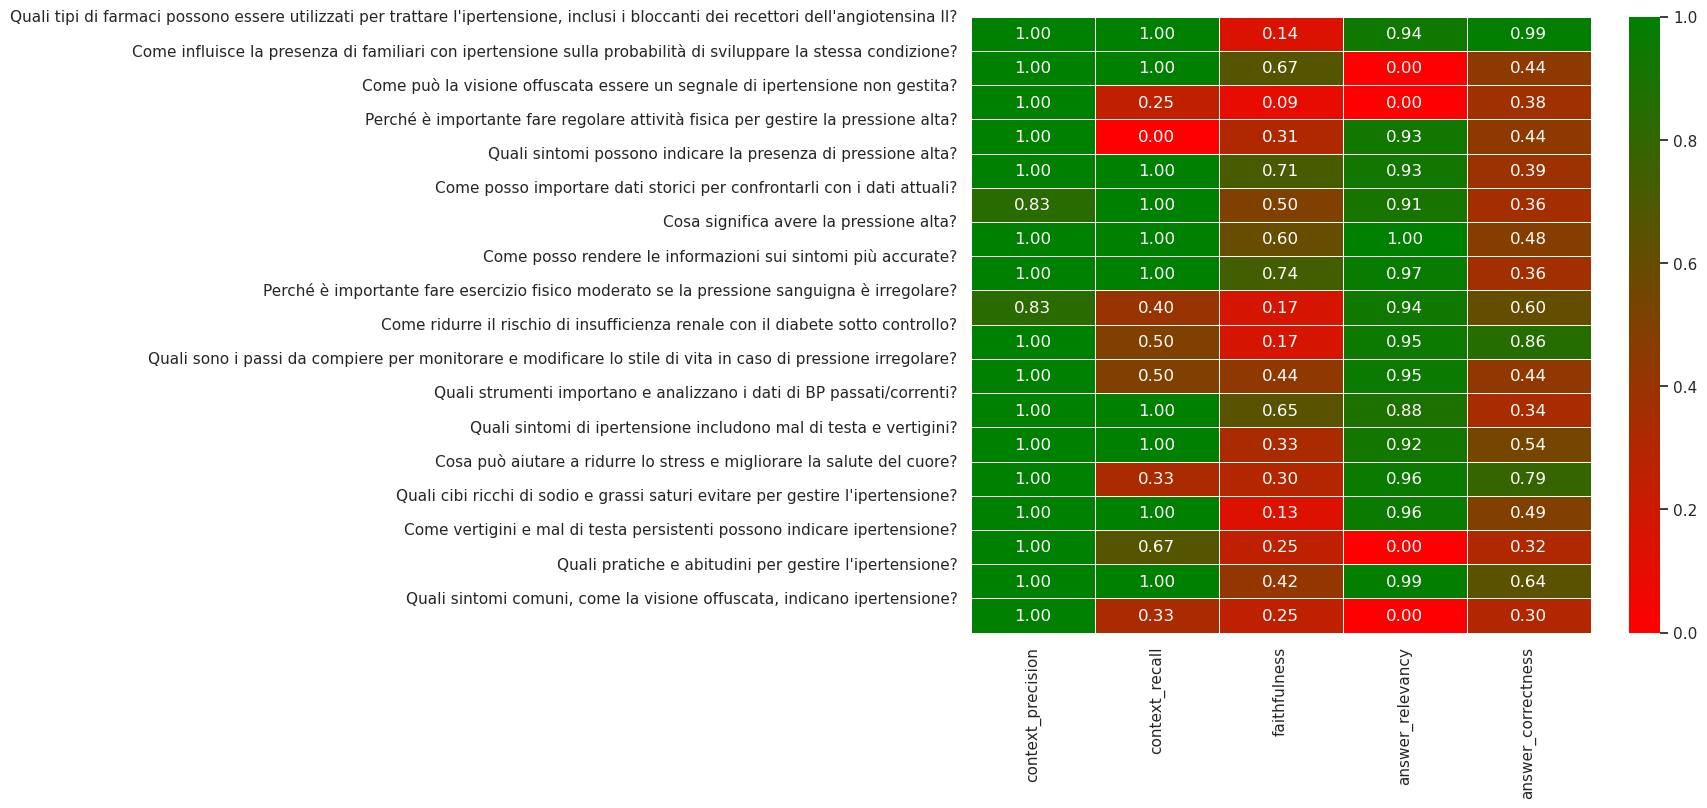

In [524]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#df = result.to_pandas()

heatmap_data = QwenMedEnsemble[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy', 'answer_correctness']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(QwenMedEnsemble['question'])), labels=QwenMedEnsemble['question'], rotation=0)

plt.show()

### VALUTAZIONE VARI RETRIEVER CON GRAFICO A RADAR E BARRE PER SINGOLO MODELLO

In [ ]:
# MI ESTRAGGO I RISULTATI SINGOLARMENTTE
llamaBase = evaluation_results["llama3.1"]["base"].to_pandas()
llamaMulti = evaluation_results["llama3.1"]["multi"].to_pandas()
llamaEnsemble = evaluation_results["llama3.1"]["ensemble"].to_pandas()
#FARE PER ALTRI MODELLI...

In [183]:
QwenMedBase = evaluation_results["echelonify/med-qwen2"]["base"].to_pandas()
QwenMedMulti = evaluation_results["echelonify/med-qwen2"]["multi"].to_pandas()
QwenMedEnsemble = evaluation_results["echelonify/med-qwen2"]["ensemble"].to_pandas()

In [ ]:
QwenMedBase[metrics] # VERIFICO LE METRICHE

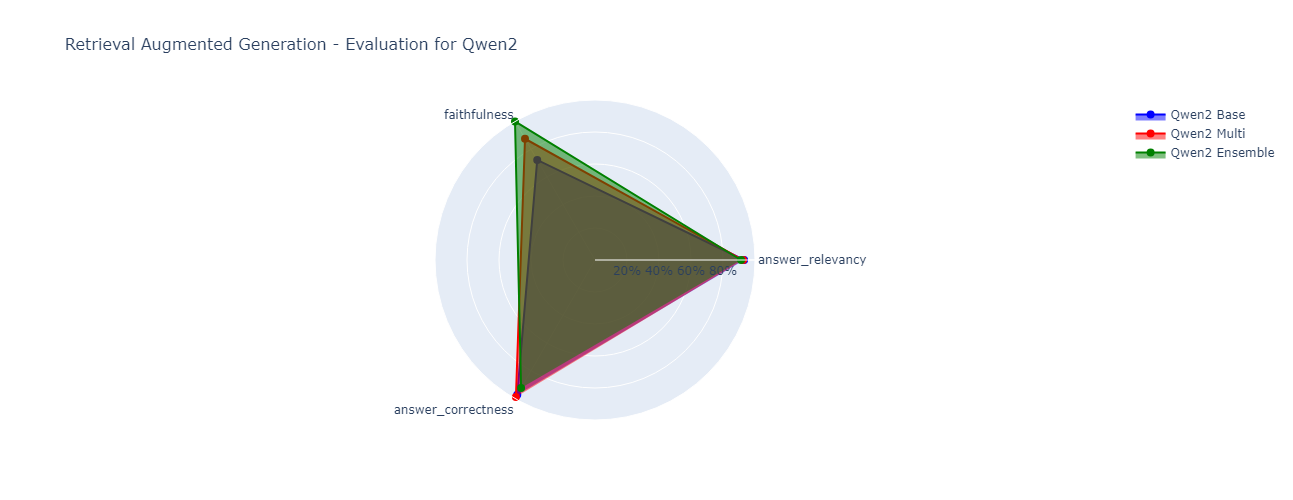

In [444]:
import plotly.graph_objects as go

metrics = ['answer_relevancy', 'faithfulness', 'answer_correctness']

fig = go.Figure()

for data, name, color in zip([Qwen2Base, Qwen2Multi, Qwen2Ensemble],
                             ['Qwen2 Base', 'Qwen2 Multi', 'Qwen2 Ensemble'],
                             ['blue', 'red', 'green']):
    fig.add_trace(go.Scatterpolar(
        r=data[metrics].values.flatten(),
        theta=metrics,
        fill='toself',
        name=name,
        line=dict(color=color, width=2),
        marker=dict(size=8, symbol='circle')
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickvals=[0.2, 0.4, 0.6, 0.8],
            ticktext=['20%', '40%', '60%', '80%']
        ),
        angularaxis=dict(
            tickfont=dict(size=12)
        )
    ),
    showlegend=True,
    legend=dict(font=dict(size=12)),
    title=dict(
        text="Retrieval Augmented Generation - Evaluation for Qwen2",
        font=dict(size=16)
    ),
    width=700,
    height=500
)

fig.show()

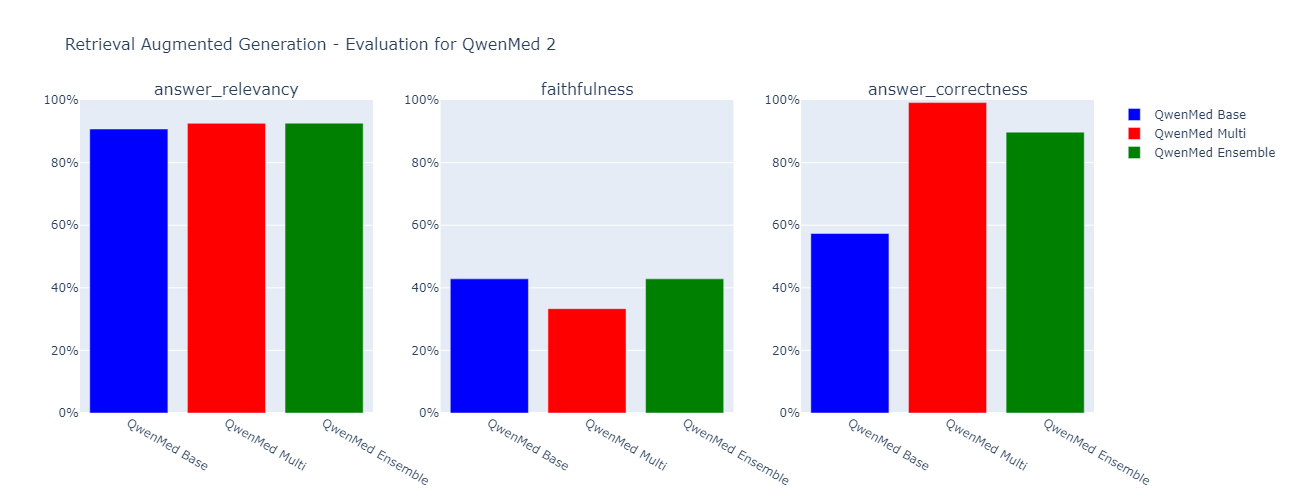

In [191]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

metrics = ['answer_relevancy', 'faithfulness', 'answer_correctness']
models = ['QwenMed Base', 'QwenMed Multi', 'QwenMed Ensemble']
colors = ['blue', 'red', 'green']

fig = make_subplots(rows=1, cols=3, subplot_titles=metrics)

for i, metric in enumerate(metrics, start=1):
    for j, (data, name, color) in enumerate(zip([QwenMedBase, QwenMedMulti, QwenMedEnsemble], models, colors)):
        fig.add_trace(
            go.Bar(
                x=[name], 
                y=[data[metric].values[0]], 
                name=name,
                marker_color=color,
                showlegend=i==1
            ),
            row=1, col=i
        )

fig.update_layout(
    title=dict(
        text="Retrieval Augmented Generation - Evaluation for QwenMed 2",
        font=dict(size=16)
    ),
    barmode='group',
    height=500,
    width=900,
    yaxis=dict(range=[0, 1], tickformat='.0%'),
    yaxis2=dict(range=[0, 1], tickformat='.0%'),
    yaxis3=dict(range=[0, 1], tickformat='.0%')
)

fig.show()

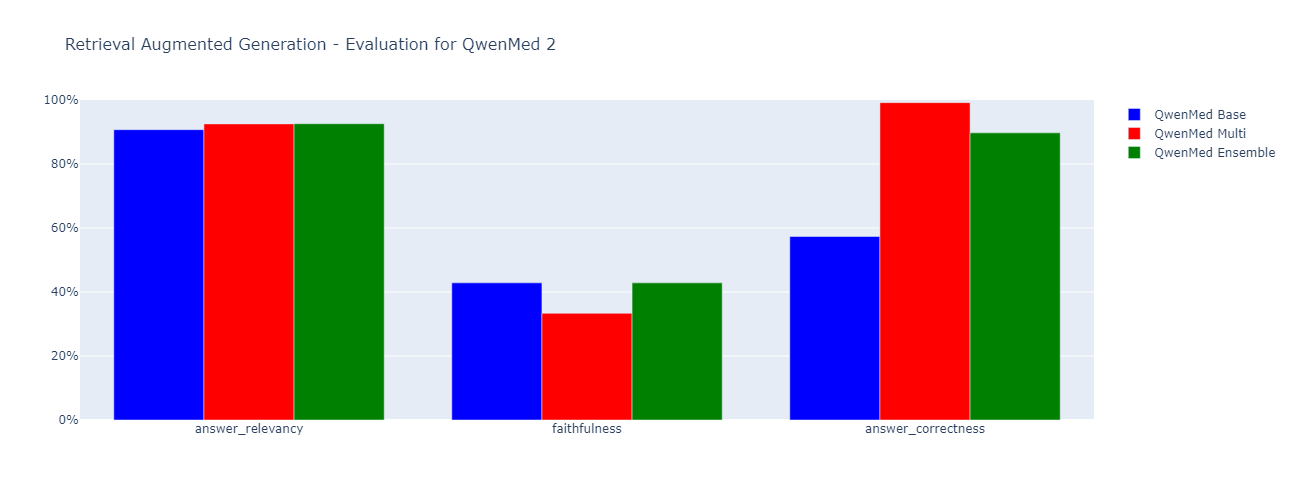

In [192]:
import plotly.graph_objects as go

metrics = ['answer_relevancy', 'faithfulness', 'answer_correctness']
models = ['QwenMed Base', 'QwenMed Multi', 'QwenMed Ensemble']
colors = ['blue', 'red', 'green']

fig = go.Figure()

for data, name, color in zip([QwenMedBase, QwenMedMulti, QwenMedEnsemble], models, colors):
    fig.add_trace(go.Bar(
        name=name,
        x=metrics,
        y=data[metrics].values.flatten(),
        marker_color=color
    ))

fig.update_layout(
    title=dict(
        text="Retrieval Augmented Generation - Evaluation for QwenMed 2",
        font=dict(size=16)
    ),
    barmode='group',
    yaxis=dict(range=[0, 1], tickformat='.0%'),
    height=500,
    width=800
)

fig.show()

## GRAFICI

### GRAFICO DI COMPARAZIONE TRA DUE MODELLI

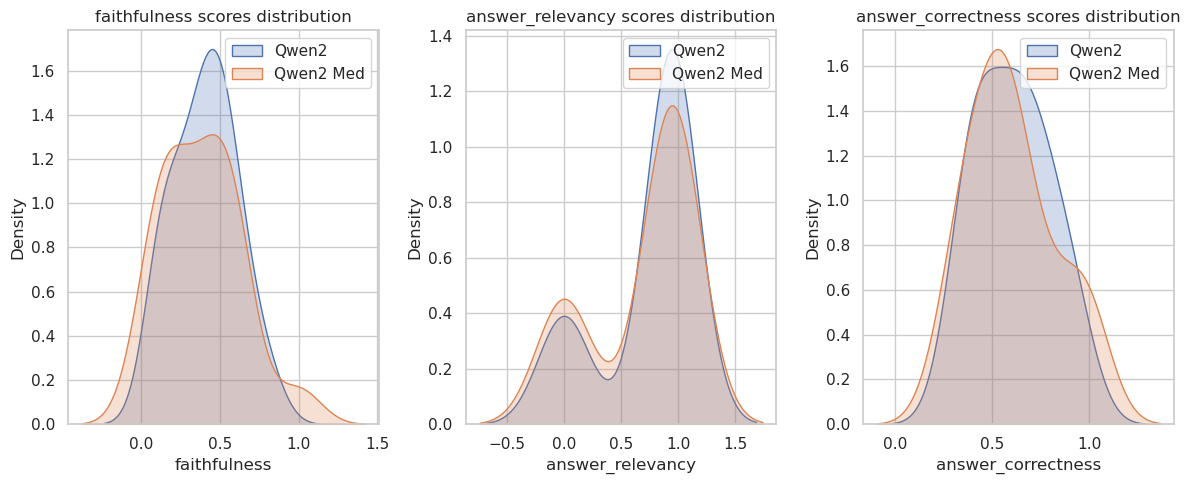

In [588]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Funzione di analisi
def analysis(model1, model2):
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    columns = model1.columns
    for i, col in enumerate(columns):
        sns.kdeplot(data=model1[col].dropna(), legend=False, ax=axs[i], fill=True, label='Qwen2') #MODIFICA NOME MODELLO
        sns.kdeplot(data=model2[col].dropna(), legend=False, ax=axs[i], fill=True, label='Qwen2 Med') #MODIFICA NOME MODELLO
        axs[i].set_title(f'{col} scores distribution')
        axs[i].legend()
    plt.tight_layout()
    plt.show()


# Chiamata alla funzione di analisi
analysis(
    Qwen2Base[['faithfulness', 'answer_relevancy', 'answer_correctness']],
    QwenMedBase[['faithfulness', 'answer_relevancy', 'answer_correctness']]
)


### Facendo la media delle metriche

test su due modelli a scelta

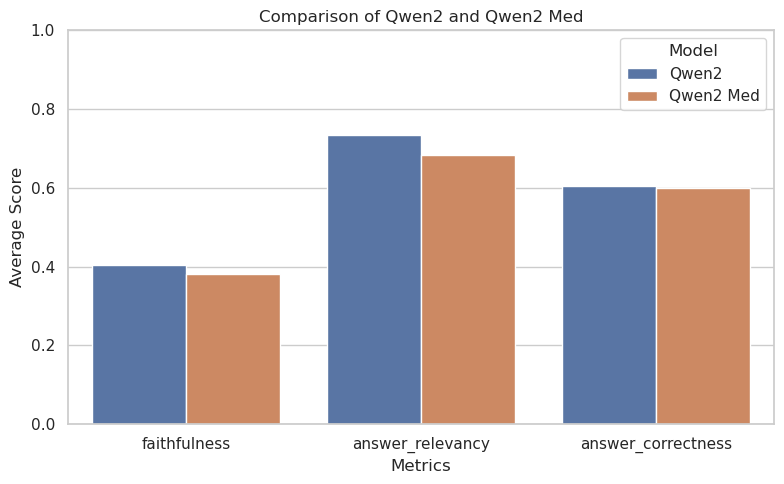

In [603]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def comparison_bar_plot(model1, model2, model1_name, model2_name):
    # Calcola le medie per ciascun modello
    mean1 = model1.mean()
    mean2 = model2.mean()
    
    # Crea un DataFrame con le medie
    df = pd.DataFrame({
        'Metric': mean1.index,
        model1_name: mean1.values,
        model2_name: mean2.values
    })
    
    # Melte il DataFrame per la visualizzazione con Seaborn
    df_melted = df.melt('Metric', var_name='Model', value_name='Score')
    
    # Crea il grafico
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
    
    plt.title(f'Comparison of {model1_name} and {model2_name}')
    plt.xlabel('Metrics')
    plt.ylabel('Average Score')
    plt.ylim(0, 1)  # Assumendo che i punteggi siano su una scala da 0 a 5
    
    plt.tight_layout()
    plt.show()

# Chiamata alla funzione
comparison_bar_plot(
    Qwen2Base[['faithfulness', 'answer_relevancy', 'answer_correctness']],
    QwenMedBase[['faithfulness', 'answer_relevancy', 'answer_correctness']],
    'Qwen2',
    'Qwen2 Med'
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def comparison_bar_plot(model1, model2, model1_name, model2_name):
    # Calcola le medie per ciascun modello
    mean1 = model1.mean()
    mean2 = model2.mean()
    
    # Crea un DataFrame con le medie
    df = pd.DataFrame({
        'Metric': mean1.index,
        model1_name: mean1.values,
        model2_name: mean2.values
    })
    
    # Melte il DataFrame per la visualizzazione con Seaborn
    df_melted = df.melt('Metric', var_name='Model', value_name='Score')
    
    # Crea il grafico
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
    
    plt.title(f'Comparison of {model1_name} and {model2_name}')
    plt.xlabel('Metrics')
    plt.ylabel('Average Score')
    plt.ylim(0, 1)  # Assumendo che i punteggi siano su una scala da 0 a 1
    
    plt.tight_layout()
    plt.show()

# Assumiamo che i seguenti DataFrame siano già caricati:
# Qwen2Base, QwenMedBase, Qwen2Large

# Confronto tra Qwen2Base e QwenMedBase
comparison_bar_plot(
    Qwen2Base[['answer_relevancy', 'answer_correctness']],
    QwenMedBase[['answer_relevancy', 'answer_correctness']],
    'Qwen2 Base',
    'Qwen2 Med Base'
)

# Confronto tra Qwen2Multi e QwenMedMulti
comparison_bar_plot(
    Qwen2Multi[['answer_relevancy', 'answer_correctness']],
    QwenMedMulti[['answer_relevancy', 'answer_correctness']],
    'Qwen2 Multi',
    'Qwen2 Med Multi'
)

# Confronto tra Qwen2Ensemble e QwenMedEnsemble
comparison_bar_plot(
    Qwen2Ensemble[['answer_relevancy', 'answer_correctness']],
    QwenMedEnsemble[['answer_relevancy', 'answer_correctness']],
    'Qwen2 Ensemble',
    'Qwen2 Med Ensemble'
)
#############################################################################################

# Confronto tra LlamaBase e LlamaMedBase
comparison_bar_plot(
    LlamaBase[['answer_relevancy', 'answer_correctness']],
    LlamaMedBase[['answer_relevancy', 'answer_correctness']],
    'Llama Base',
    'Llama Med Base'
)

# Confronto tra LlamaMulti e LlamaMedMulti
comparison_bar_plot(
    LlamaMulti[['answer_relevancy', 'answer_correctness']],
    LlamaMedMulti[['answer_relevancy', 'answer_correctness']],
    'Llama Multi',
    'Llama Med Multi'
)

# Confronto tra LlamaEnsemble e LlamaMedEnsemble
comparison_bar_plot(
    LlamaEnsemble[['answer_relevancy', 'answer_correctness']],
    LlamaMedEnsemble[['answer_relevancy', 'answer_correctness']],
    'Llama Ensemble',
    'Llama Med Ensemble'
)

# Se hai altri modelli, puoi aggiungere ulteriori confronti qui
# Per esempio:
# comparison_bar_plot(
#     Qwen3Base[['faithfulness', 'answer_relevancy', 'answer_correctness']],
#     Qwen3Large[['faithfulness', 'answer_relevancy', 'answer_correctness']],
#     'Qwen3 Base',
#     'Qwen3 Large'
# )

Grafico salvato come immaginiPDF/qwen_models_comparison.pdf


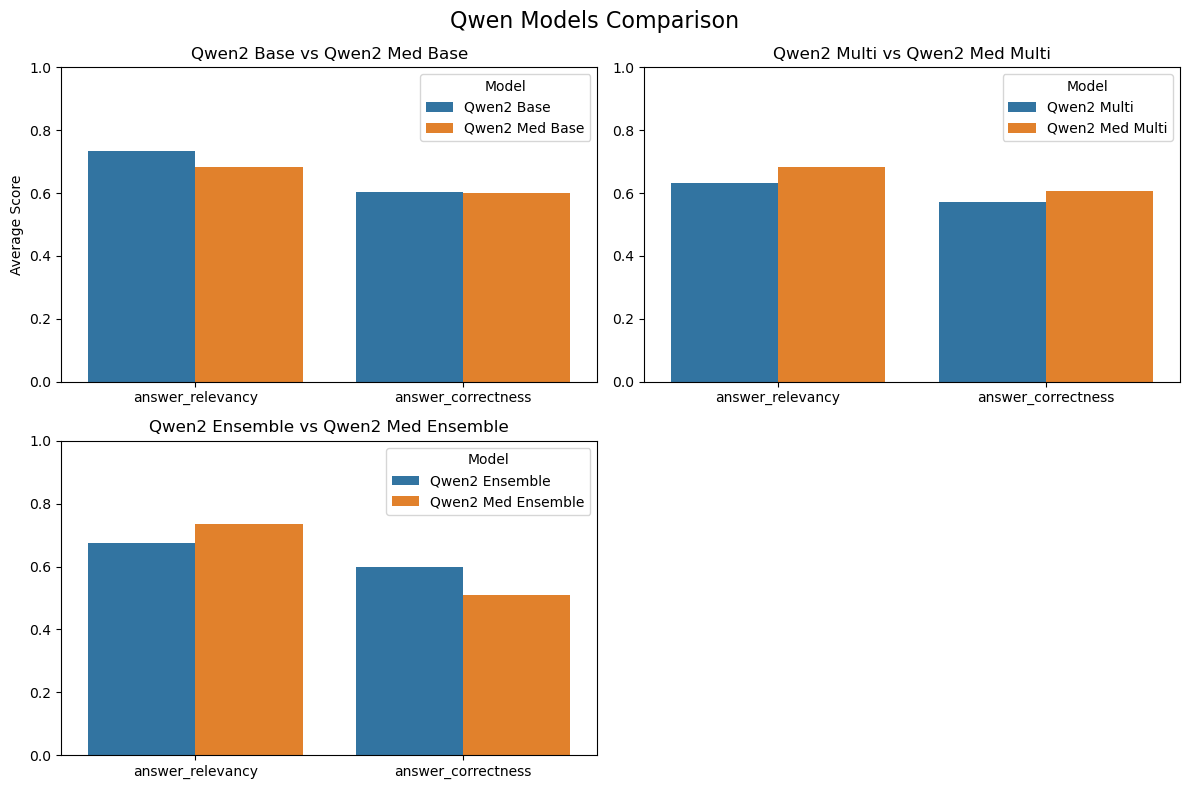

Grafico salvato come immaginiPDF/llama_models_comparison.pdf


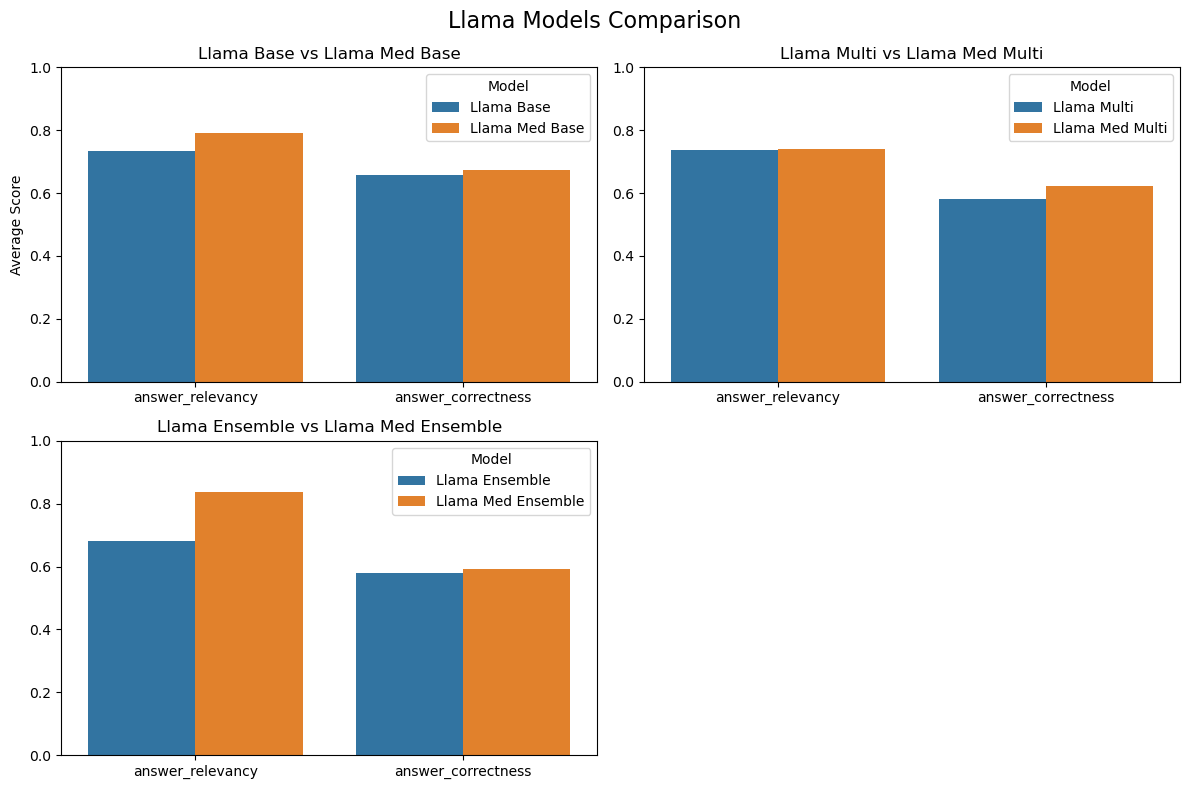

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Creazione della cartella immaginiPDF se non esiste
if not os.path.exists('immaginiPDF'):
    os.makedirs('immaginiPDF')

def comparison_subplots(models, model_names, title, filename):
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle(title, fontsize=16)
    
    # Creazione di un layout personalizzato
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
    
    axes = [fig.add_subplot(gs[0, 0]),  # Primo grafico
            fig.add_subplot(gs[0, 1]),  # Secondo grafico
            fig.add_subplot(gs[1, 0])]  # Terzo grafico (sotto al primo)
    
    for i in range(0, len(models), 2):
        model1, model2 = models[i], models[i+1]
        model1_name, model2_name = model_names[i], model_names[i+1]
        
        mean1 = model1.mean()
        mean2 = model2.mean()
        
        df = pd.DataFrame({
            'Metric': mean1.index,
            model1_name: mean1.values,
            model2_name: mean2.values
        })
        
        df_melted = df.melt('Metric', var_name='Model', value_name='Score')
        
        sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted, ax=axes[i//2])
        
        axes[i//2].set_title(f'{model1_name} vs {model2_name}')
        axes[i//2].set_xlabel('')
        axes[i//2].set_ylim(0, 1)
        if i//2 == 0:
            axes[i//2].set_ylabel('Average Score')
        else:
            axes[i//2].set_ylabel('')
    
    plt.tight_layout()
    
    # Salva il grafico in PDF
    pdf_path = os.path.join('immaginiPDF', filename)
    plt.savefig(pdf_path, format='pdf')
    print(f"Grafico salvato come {pdf_path}")
    
    # Visualizza il grafico
    plt.show()

# Qwen models comparison
qwen_models = [
    Qwen2Base[['answer_relevancy', 'answer_correctness']],
    QwenMedBase[['answer_relevancy', 'answer_correctness']],
    Qwen2Multi[['answer_relevancy', 'answer_correctness']],
    QwenMedMulti[['answer_relevancy', 'answer_correctness']],
    Qwen2Ensemble[['answer_relevancy', 'answer_correctness']],
    QwenMedEnsemble[['answer_relevancy', 'answer_correctness']]
]
qwen_model_names = ['Qwen2 Base', 'Qwen2 Med Base', 'Qwen2 Multi', 'Qwen2 Med Multi', 'Qwen2 Ensemble', 'Qwen2 Med Ensemble']
comparison_subplots(qwen_models, qwen_model_names, 'Qwen Models Comparison', 'qwen_models_comparison.pdf')

# Llama models comparison
llama_models = [
    LlamaBase[['answer_relevancy', 'answer_correctness']],
    LlamaMedBase[['answer_relevancy', 'answer_correctness']],
    LlamaMulti[['answer_relevancy', 'answer_correctness']],
    LlamaMedMulti[['answer_relevancy', 'answer_correctness']],
    LlamaEnsemble[['answer_relevancy', 'answer_correctness']],
    LlamaMedEnsemble[['answer_relevancy', 'answer_correctness']]
]
llama_model_names = ['Llama Base', 'Llama Med Base', 'Llama Multi', 'Llama Med Multi', 'Llama Ensemble', 'Llama Med Ensemble']
comparison_subplots(llama_models, llama_model_names, 'Llama Models Comparison', 'llama_models_comparison.pdf')

Grafico salvato come immaginiPDF/comparison_base.pdf


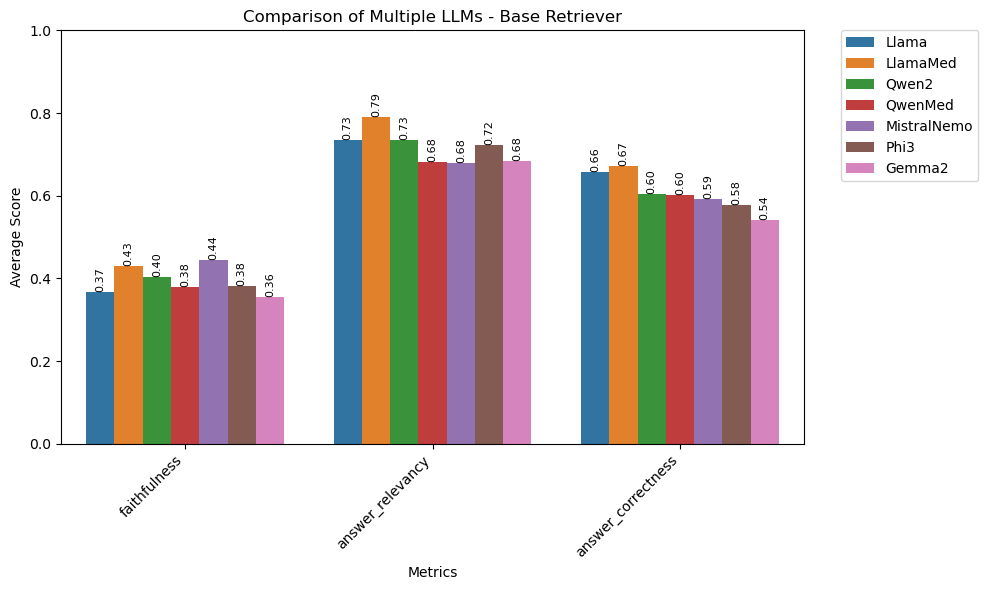

Grafico salvato come immaginiPDF/comparison_multi.pdf


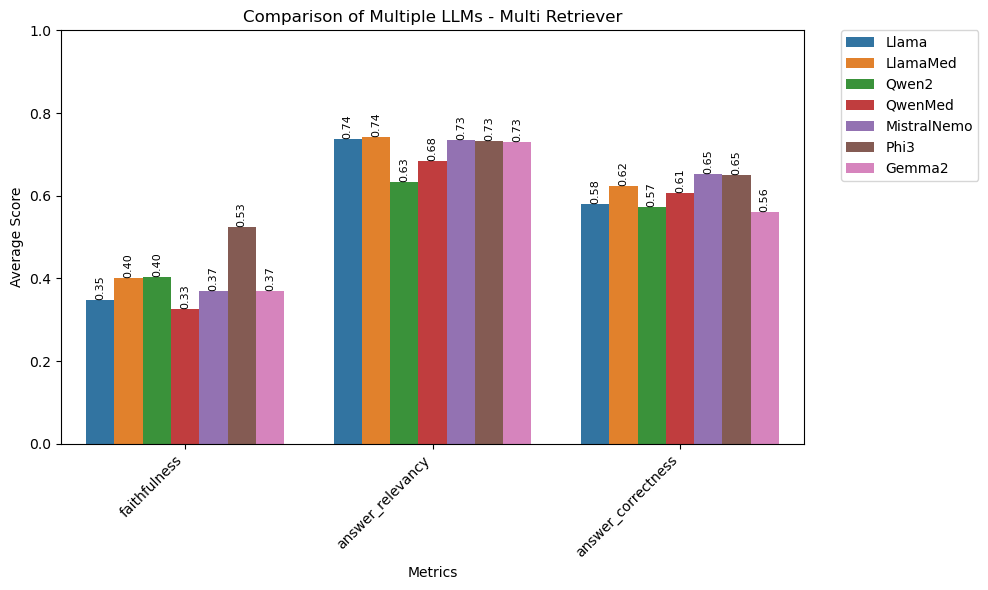

Grafico salvato come immaginiPDF/comparison_ensemble.pdf


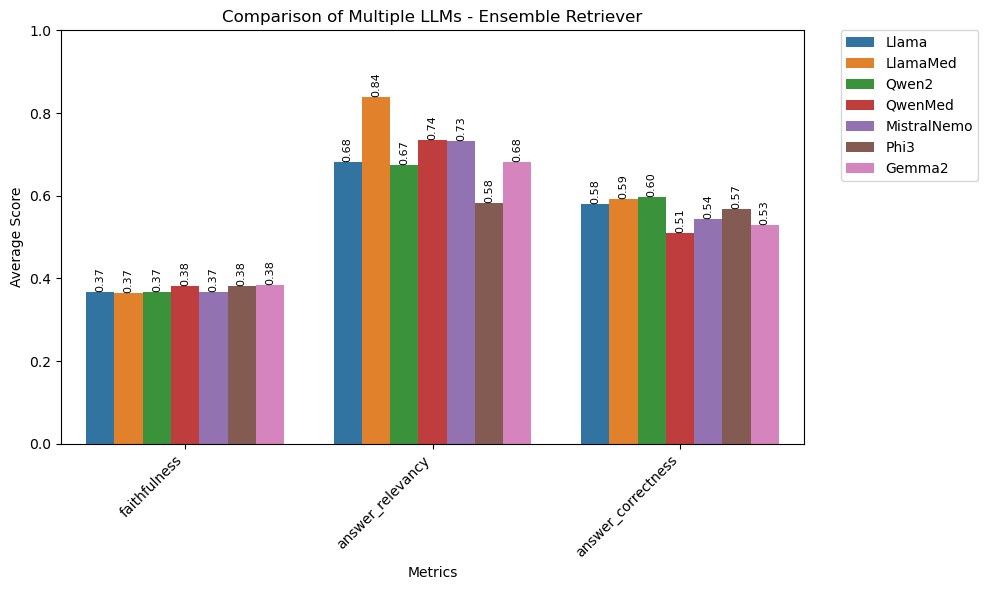

I grafici sono stati salvati nella cartella 'immaginiPDF' come 'comparison_base.pdf', 'comparison_multi.pdf', e 'comparison_ensemble.pdf'.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Creazione della cartella immaginiPDF se non esiste
if not os.path.exists('immaginiPDF'):
    os.makedirs('immaginiPDF')

def comparison_bar_plot_multiple(models_dict, scenario):
    # Prepara i dati
    df_list = []
    for model_name, model_data in models_dict.items():
        mean = model_data[['faithfulness', 'answer_relevancy', 'answer_correctness']].mean()
        df = pd.DataFrame({'Metric': mean.index, 'Score': mean.values, 'Model': model_name})
        df_list.append(df)
    
    df_combined = pd.concat(df_list, ignore_index=True)
    
    # Crea il grafico
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=df_combined)
    
    plt.title(f'Comparison of Multiple LLMs - {scenario} Retriever')
    plt.xlabel('Metrics')
    plt.ylabel('Average Score')
    plt.ylim(0, 1)
    
    # Ruota le etichette dell'asse x per una migliore leggibilità
    plt.xticks(rotation=45, ha='right')
    
    # Sposta la legenda fuori dal grafico
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Aggiungi le etichette dei valori sopra le barre
    for i, bar in enumerate(plt.gca().patches):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{bar.get_height():.2f}',
            ha='center', va='bottom', rotation=90, fontsize=8
        )
    
    plt.tight_layout()
    
    # Salva il grafico in PDF
    pdf_path = os.path.join('immaginiPDF', f'comparison_{scenario.lower()}.pdf')
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    print(f"Grafico salvato come {pdf_path}")
    
    # Visualizza il grafico
    plt.show()

# Dizionari contenenti i dati per ciascun scenario
base_models_dict = {
    'Llama': LlamaBase,
    'LlamaMed': LlamaMedBase,
    'Qwen2': Qwen2Base,
    'QwenMed': QwenMedBase,
    'MistralNemo': MistralNemoBase,
    'Phi3': Phi3Base,
    'Gemma2': Gemma2Base
}
multi_models_dict = {
    'Llama': LlamaMulti,
    'LlamaMed': LlamaMedMulti,
    'Qwen2': Qwen2Multi,
    'QwenMed': QwenMedMulti,
    'MistralNemo': MistralNemoMulti,
    'Phi3': Phi3Multi,
    'Gemma2': Gemma2Multi
}
ensemble_models_dict = {
    'Llama': LlamaEnsemble,
    'LlamaMed': LlamaMedEnsemble,
    'Qwen2': Qwen2Ensemble,
    'QwenMed': QwenMedEnsemble,
    'MistralNemo': MistralNemoEnsemble,
    'Phi3': Phi3Ensemble,
    'Gemma2': Gemma2Ensemble
}

# Creazione dei grafici per ciascuno scenario
comparison_bar_plot_multiple(base_models_dict, 'Base')
comparison_bar_plot_multiple(multi_models_dict, 'Multi')
comparison_bar_plot_multiple(ensemble_models_dict, 'Ensemble')

print("I grafici sono stati salvati nella cartella 'immaginiPDF' come 'comparison_base.pdf', 'comparison_multi.pdf', e 'comparison_ensemble.pdf'.")

### Comparazione singolo llm per tutti i retriever per metrica scelta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def single_model_scenario_comparison(model_name, base_df, multi_df, ensemble_df, metric):
    # Prepara i dati
    data = {
        'Scenario': ['Base', 'Multi', 'Ensemble'],
        'Score': [
            base_df[metric].mean(),
            multi_df[metric].mean(),
            ensemble_df[metric].mean()
        ]
    }
    df = pd.DataFrame(data)
    
    # Crea il grafico
    plt.figure(figsize=(7, 5))
    sns.barplot(x='Scenario', y='Score', data=df)
    
    plt.title(f'{model_name}: {metric} for any Retriever')
    plt.xlabel('Retriever')
    plt.ylabel('Average Score')
    plt.ylim(0, 1)
    
    # Aggiungi le etichette dei valori sopra le barre
    for i, v in enumerate(df['Score']):
        plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Lista dei modelli
models = ['Llama', 'LlamaMed', 'Qwen2', 'QwenMed', 'MistralNemo', 'Phi3', 'Gemma2']

# Dizionari per i DataFrame di ogni scenario
base_dfs = {
    'Llama': LlamaBase,
    'LlamaMed': LlamaMedBase,
    'Qwen2': Qwen2Base,
    'QwenMed': QwenMedBase,
    'MistralNemo': MistralNemoBase,
    'Phi3': Phi3Base,
    'Gemma2': Gemma2Base
}

multi_dfs = {
    'Llama': LlamaMulti,
    'LlamaMed': LlamaMedMulti,
    'Qwen2': Qwen2Multi,
    'QwenMed': QwenMedMulti,
    'MistralNemo': MistralNemoMulti,
    'Phi3': Phi3Multi,
    'Gemma2': Gemma2Multi
}

ensemble_dfs = {
    'Llama': LlamaEnsemble,
    'LlamaMed': LlamaMedEnsemble,
    'Qwen2': Qwen2Ensemble,
    'QwenMed': QwenMedEnsemble,
    'MistralNemo': MistralNemoEnsemble,
    'Phi3': Phi3Ensemble,
    'Gemma2': Gemma2Ensemble
}

# Metrica da visualizzare
metric = 'answer_relevancy'

# Crea un grafico per ogni modello
for model in models:
    single_model_scenario_comparison(
        model,
        base_dfs[model],
        multi_dfs[model],
        ensemble_dfs[model],
        metric
    )

grafico che raggruppa per retriever e crea un unico grafico

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def multi_model_multi_metric_comparison(models, base_dfs, multi_dfs, ensemble_dfs, metrics):
    # Cicla attraverso ogni metrica
    for metric in metrics:
        # Crea una lista per memorizzare i dati per ogni metrica
        data = []

        # Popola i dati per ogni modello e scenario
        for model_name in models:
            data.append({
                'Model': model_name,
                'Scenario': 'Base',
                'Score': base_dfs[model_name][metric].mean()
            })
            data.append({
                'Model': model_name,
                'Scenario': 'Multi',
                'Score': multi_dfs[model_name][metric].mean()
            })
            data.append({
                'Model': model_name,
                'Scenario': 'Ensemble',
                'Score': ensemble_dfs[model_name][metric].mean()
            })

        # Converti in DataFrame
        df = pd.DataFrame(data)

        # Crea il grafico per la metrica corrente
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='Model', y='Score', hue='Scenario', data=df)

        plt.title(f'Comparison of {metric} across models and retriever')
        plt.xlabel('Model')
        plt.ylabel('Average Score')
        plt.ylim(0, 1)

        # Aggiungi le etichette dei valori sopra le barre
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.3f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=8)

        plt.legend(title='Retriever')
        plt.tight_layout()
        plt.show()

# Lista delle metriche
metrics = ['answer_relevancy', 'answer_correctness', 'faithfulness']

# Esegui il confronto multi-modello e multi-metrica
multi_model_multi_metric_comparison(models, base_dfs, multi_dfs, ensemble_dfs, metrics)


### GRAFICO COMPARAZIONE PIU' MODELLI DISTRIBUTION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def multi_model_analysis(*args):
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    
    for i, metric in enumerate(metrics):
        for df, label in args:
            sns.kdeplot(data=df[metric].dropna(), ax=axs[i], fill=True, label=label)
        
        axs[i].set_title(f'{metric} scores distribution')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# Chiamata alla funzione di analisi
multi_model_analysis(
    (LlamaBase[metrics], 'Llama-Base'),
   # (LlamaMulti[metrics], 'Llama-Multi'),
   # (LlamaEnsemble[metrics], 'Llama-Ensemble'),
    (LlamaMedBase[metrics], 'LlamaMed-Base'),
   # (LlamaMedMulti[metrics], 'LlamaMed-Multi'),
   # (LlamaMedEnsemble[metrics], 'LlamaMed-Ensemble'),
    (Qwen2Base[metrics], 'Qwen2-Base'),
   # (Qwen2Multi[metrics], 'Qwen2-Multi'),
   # (Qwen2Ensemble[metrics], 'Qwen2-Ensemble'),
    (QwenMedBase[metrics], 'QwenMed-Base'),
   # (QwenMedMulti[metrics], 'QwenMed-Multi'),
   # (QwenMedEnsemble[metrics], 'QwenMed-Ensemble'),
    (MistralNemoBase[metrics], 'MistralNemo-Base'),
   #(MistralNemoMulti[metrics], 'MistralNemo-Multi'),
   # (MistralNemoEnsemble[metrics], 'MistralNemo-Ensemble'),
    (Phi3Base[metrics], 'Phi3-Base'),
   # (Phi3Multi[metrics], 'Phi3-Multi'),
   # (Phi3Ensemble[metrics], 'Phi3-Ensemble')
    (Gemma2Base[metrics], 'Gemma2-Base')
   # (Gemma2Multi[metrics], 'Gemma2-Multi'),
   # (Gemma2Ensemble[metrics], 'Gemma2-Ensemble')
)

## ALTRI GRAFICI DA PROVATI

### HEATMAP

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Preparazione dei dati
models = ['Llama','LlamaMed', 'Qwen2','QwenMed', 'MistralNemo', 'Phi3','Gemma2'] #Modelli da testare : 'Qwen2','QwenMed', 'MistralNemo', 'Phi3','Gemma2'
retrievers = ['Base', 'Multi', 'Ensemble']
metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']

data = []
for model in models:
    for retriever in retrievers:
        model_data = globals()[f"{model}{retriever}"]
        avg_scores = model_data[metrics].mean()
        data.append([f"{model}-{retriever}"] + list(avg_scores))

df = pd.DataFrame(data, columns=['Model'] + metrics)
df_pivot = df.set_index('Model').T

# Creazione della heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Model Comparison - Average Scores')
plt.tight_layout()
plt.show()

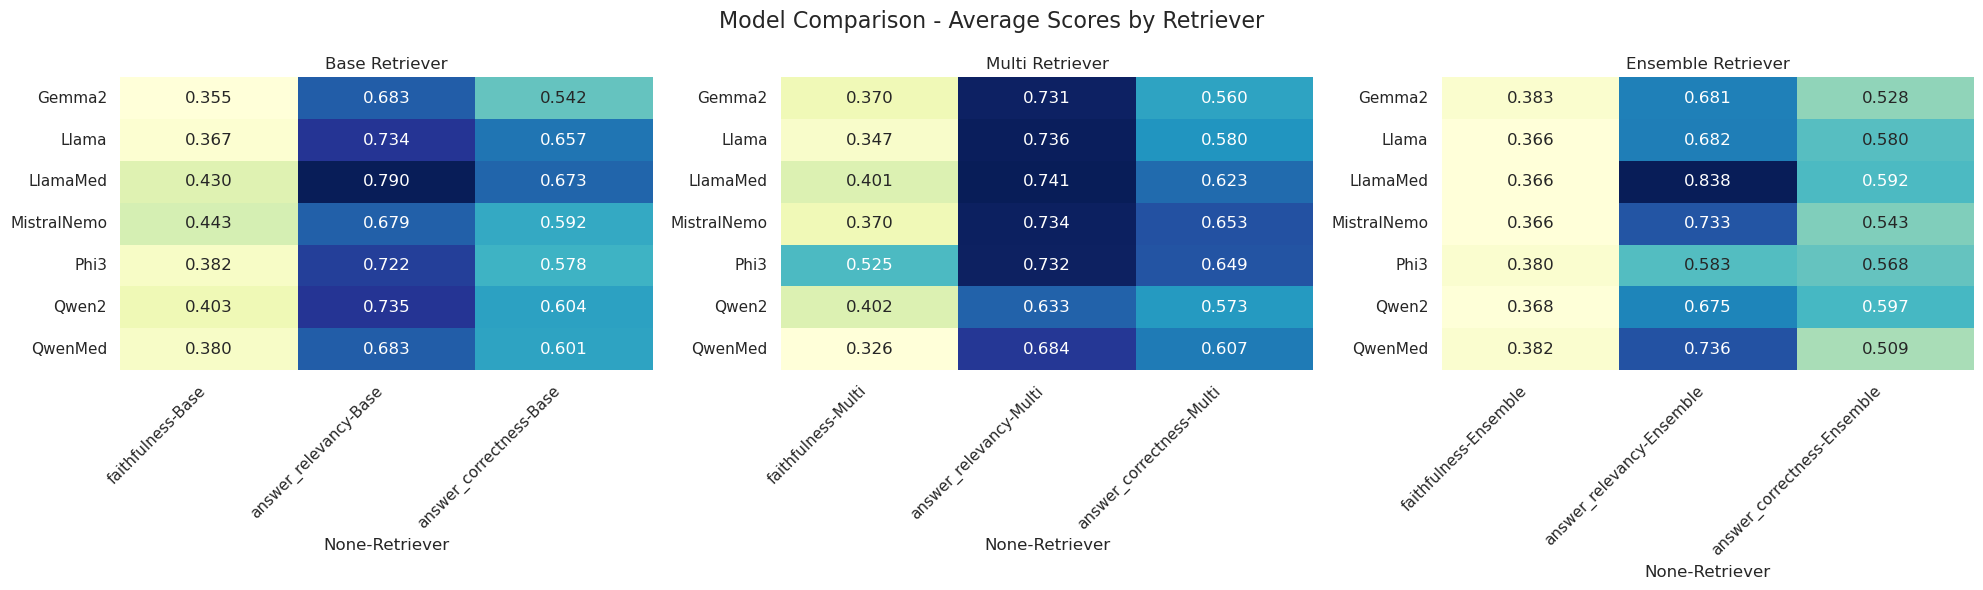

In [540]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Preparazione dei dati
models = ['Llama', 'LlamaMed', 'Qwen2', 'QwenMed', 'MistralNemo', 'Phi3', 'Gemma2']
retrievers = ['Base', 'Multi', 'Ensemble']
metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']

data = []
for model in models:
    for retriever in retrievers:
        model_data = globals()[f"{model}{retriever}"]
        avg_scores = model_data[metrics].mean()
        data.append([model, retriever] + list(avg_scores))

df = pd.DataFrame(data, columns=['Model', 'Retriever'] + metrics)

# Funzione per creare un singolo grafico
def create_heatmap(data, retriever, ax):
    df_pivot = data[data['Retriever'] == retriever].pivot(index='Model', columns='Retriever', values=metrics)
    sns.heatmap(df_pivot, annot=True, cmap='YlGnBu', fmt='.3f', ax=ax, cbar=False)
    ax.set_title(f'{retriever} Retriever')
    ax.set_ylabel('')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Creazione dei grafici
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Model Comparison - Average Scores by Retriever', fontsize=16)

for i, retriever in enumerate(retrievers):
    create_heatmap(df, retriever, axes[i])

plt.tight_layout()
plt.show()

Grafico salvato come immaginiPDF/heatmap_Base.pdf


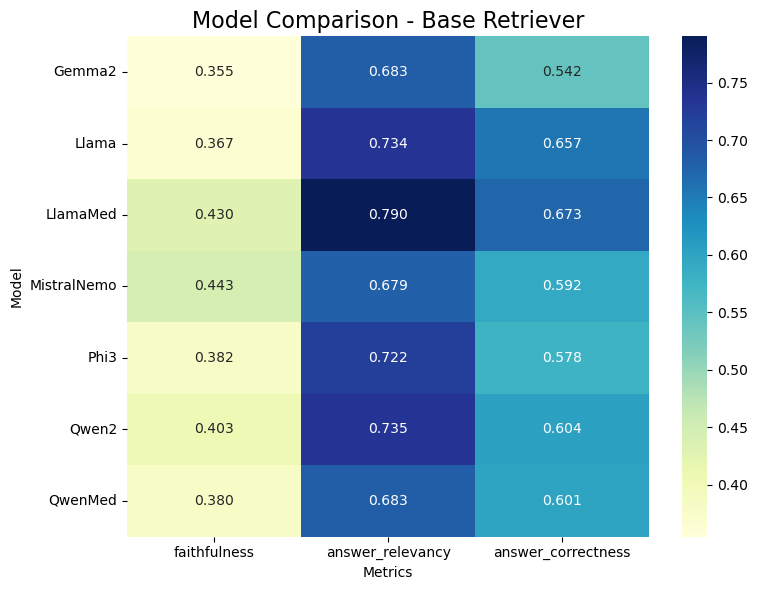

Grafico salvato come immaginiPDF/heatmap_Multi.pdf


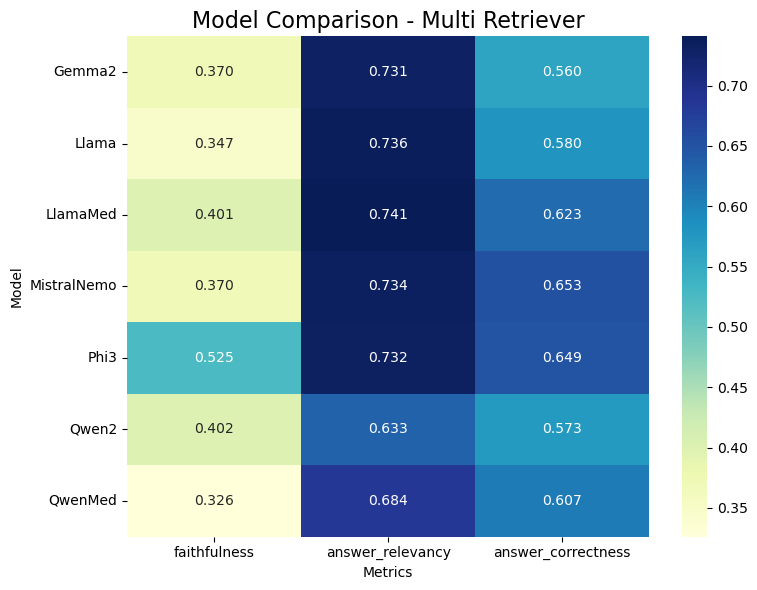

Grafico salvato come immaginiPDF/heatmap_Ensemble.pdf


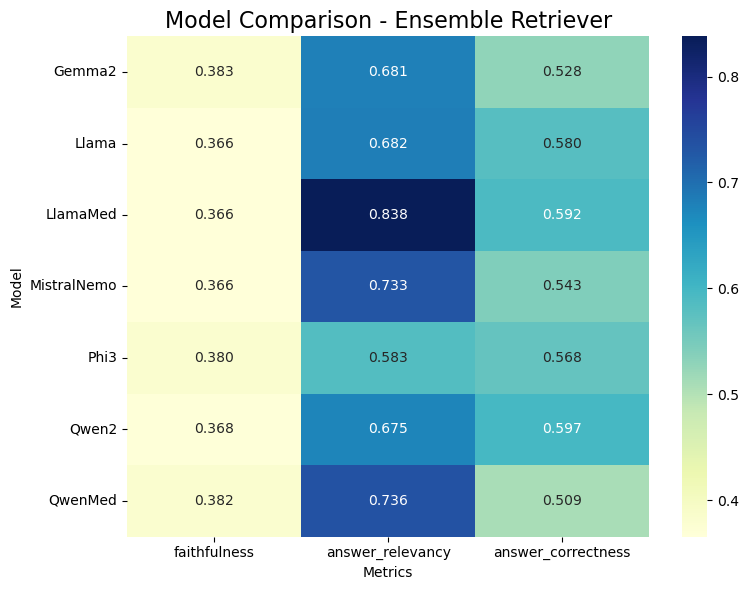

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Preparazione dei dati
models = ['Llama', 'LlamaMed', 'Qwen2', 'QwenMed', 'MistralNemo', 'Phi3', 'Gemma2']
retrievers = ['Base', 'Multi', 'Ensemble']
metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
data = []
for model in models:
    for retriever in retrievers:
        model_data = globals()[f"{model}{retriever}"]
        avg_scores = model_data[metrics].mean()
        data.append([model, retriever] + list(avg_scores))
df = pd.DataFrame(data, columns=['Model', 'Retriever'] + metrics)

# Creazione della cartella immaginiPDF se non esiste
if not os.path.exists('immaginiPDF'):
    os.makedirs('immaginiPDF')

# Funzione per creare un singolo grafico, visualizzarlo e salvarlo in PDF
def create_heatmap(data, retriever):
    plt.figure(figsize=(8, 6))
    df_filtered = data[data['Retriever'] == retriever]
    df_pivot = df_filtered.pivot(index='Model', values=metrics, columns='Retriever')
    df_pivot = df_pivot.droplevel(0, axis=1)  # Remove the 'Retriever' level from columns
    
    sns.heatmap(df_pivot, annot=True, cmap='YlGnBu', fmt='.3f', cbar=True)
    plt.title(f'Model Comparison - {retriever} Retriever', fontsize=16)
    plt.ylabel('Model')
    
    plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['faithfulness', 'answer_relevancy', 'answer_correctness'], ha='center')
    plt.xlabel('Metrics')
    plt.tight_layout()
    
    # Salva il grafico in PDF
    pdf_filename = os.path.join('immaginiPDF', f'heatmap_{retriever}.pdf')
    plt.savefig(pdf_filename, format='pdf')
    print(f"Grafico salvato come {pdf_filename}")
    
    # Visualizza il grafico
    plt.show()

# Creazione dei grafici separati
for retriever in retrievers:
    create_heatmap(df, retriever)

### RADAR CHART

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def radar_chart(data, categories, title):
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)

    for i, (model, scores) in enumerate(data.items()):
        values = scores + scores[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)

    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Preparazione dei dati
models = ['LlamaMed']#'Qwen2','QwenMed', 'MistralNemo', 'Phi3'
retrievers = ['Base', 'Multi']#'Multi', 'Ensemble
metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']

data = {}
for model in models:
    for retriever in retrievers:
        model_data = globals()[f"{model}{retriever}"]
        avg_scores = model_data[metrics].mean()
        data[f"{model}-{retriever}"] = list(avg_scores)

# Creazione del radar chart
plt.figure(figsize=(10, 10))
radar_chart(data, metrics, 'Model Comparison - Average Scores')
plt.tight_layout()
plt.show()

### BAR PLOT

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Preparazione dei dati
models = ['Qwen2']#'LlamaMed' 'Qwen2','QwenMed', 'MistralNemo', 'Phi3','Gemma2'
retrievers = ['Base', 'Multi', 'Ensemble']
metrics = [ 'answer_correctness', ]#'answer_correctness''faithfulness',

data = []
for model in models:
    for retriever in retrievers:
        model_data = globals()[f"{model}{retriever}"]
        avg_scores = model_data[metrics].mean()
        data.append([f"{model}-{retriever}"] + list(avg_scores))

df = pd.DataFrame(data, columns=['Model'] + metrics)

# Creazione del bar plot
df.set_index('Model').plot(kind='bar', figsize=(15, 8))
plt.title('Model Comparison - Average Scores')
plt.xlabel('Model-Retriever')
plt.ylabel('Average Score')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()